In [151]:
#---- User input-----#
#--------------------#
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
# Experimental values for input
# n=2.46
# n2=1.25*10^-18 m^2/V^2
# wavelength=1.53um
# slab thickness = wavelength
# input amplitude a=1.927*10^8 V/m, time averaged
amp = np.arange(0.007*10**3,1.14*10**3,0.0707*10**3) # amplitude of source
resolution = 90
k = 4.1*10**-6 #4.1*10**-7        # Kerr susceptibility
n=2.46         # index

In [152]:
def nl_cw(amp,resolution,k,n):
    sz = 10          # size of cell in z direction
    dpml = 1        # PML thickness
    time_set_start=2000         # simulation run time start
    time_set=3000-time_set_start         # simulation run time

    #----Continuous Source
    frq_cs=1/1.53          # meep frequency
    cs_width=100          #the inverse of the exponential rate at which the current turns off and on

    # frequency range for monitors
    nfreq = 1
    fmin = 1/1.53
    fmax = 1/1.53

    nfreq_nl = 300
    fmin_nl = 1/1.6
    fmax_nl = 1/0.13

    # Geometry
    d_s=1.53# slab thickness
    pos_s=0# slab position
    
    #################################################################
    # Reference simulation (source only)
    #################################################################
    geometry = [mp.Block(center=mp.Vector3(0,0,pos_s),size=mp.Vector3(0,0,d_s), material=mp.Medium(index=n, chi3=[] ))]
    geometry2 = [mp.Block(center=mp.Vector3(0,0,pos_s),size=mp.Vector3(0,0,d_s), material=mp.Medium(index=n, chi3=k ))]

    dimensions = 1
    cell = mp.Vector3(0, 0, sz)
    pml_layers = mp.PML(dpml)
    default_material = mp.Medium(index=1, chi3=[])

    sources = mp.Source(mp.ContinuousSource(frq_cs, width=cs_width), component=mp.Ex,
                        center=mp.Vector3(0, 0, -0.5*sz + dpml), amplitude=amp)

    sim = mp.Simulation(cell_size=cell,
                        geometry=[],
                        sources=[sources],
                        boundary_layers=[pml_layers],
                        default_material=default_material,
                        resolution=resolution,
                        dimensions=dimensions)
    dx=1/resolution
    nl_mon_ref = sim.add_flux(0.5 * (fmin_nl + fmax_nl), fmax_nl - fmin_nl, nfreq_nl,
                            mp.FluxRegion(mp.Vector3(0, 0, -0.5*sz + dpml+dx)))
    sim.run(until=time_set_start)
    trans_ref = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml-dx)))
    #refl_ref = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
    #                        mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 4)))


    #         Define E field monitor
    dt=0.5*dx
    tm_val_x=[]
    def get_dot(sim):	
        tm_val_x.append(sim.get_array(size=mp.Vector3(), center=mp.Vector3(0,0,sz/2-dpml-dx), component=mp.Ex))
    #        #        #        #    
    sim.run(mp.at_every(dt,get_dot),until=time_set)
    #         plot results

    #         Save reference data
    freqs_ref = mp.get_flux_freqs(trans_ref)
    #plt_range_ref=1/np.asarray(freqs_ref)
    box_x1_trans_ref = mp.get_fluxes(trans_ref)
    flux_ref=np.asarray(box_x1_trans_ref)

    box_nl_ref_dat=sim.get_flux_data(nl_mon_ref)
    box_nl_ref = mp.get_fluxes(nl_mon_ref)
    flux_nl_ref=np.asarray(box_nl_ref)

    tm_val_x1=np.array(tm_val_x)
    max_ind=np.size(tm_val_x1)
    c=3*10**8 # m/s speed of light
    mon_t=[]
    for n in np.arange(0,max_ind,1):
        mon_tmp=(dt+dt*n)*(10**-6/c)*10**15 # s
        mon_t.append(mon_tmp)

    #################################################################
    # 1d simulation of a plane wave propagating through a linear slab
    #################################################################
    sim.reset_meep()
    sim = mp.Simulation(cell_size=cell,
                        geometry=geometry,
                        sources=[sources],
                        boundary_layers=[pml_layers],
                        default_material=default_material,
                        resolution=resolution,
                        dimensions=dimensions)

    sim.run(until=time_set_start)
    trans = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml-dx )))
    refl = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, -0.5*sz + dpml+dx)))
    tm_val_x=[]
    sim.run(mp.at_every(dt,get_dot),until=time_set)
    #         plot results
    freqs_lin = mp.get_flux_freqs(trans)
    plt_range_lin=1/np.asarray(freqs_lin)
    box_x1_trans_lin = mp.get_fluxes(trans)
    flux_lin=np.asarray(box_x1_trans_lin)
    box_x1_refl_lin = mp.get_fluxes(refl)
    flux_refl_lin=np.asarray(box_x1_refl_lin)

    tm_val_x2=np.array(tm_val_x)

    #################################################################
    # 1d simulation of a plane wave propagating through a Kerr medium
    #################################################################
    sim.reset_meep()
    #geometry = [mp.Block(center=mp.Vector3(0,0,(sz-dpml)/4),size=mp.Vector3(0,0,(sz-dpml)/2), material=mp.Medium(index=n, chi3=k ))]
    sim = mp.Simulation(cell_size=cell,
                        geometry=geometry2,
                        sources=[sources],
                        boundary_layers=[pml_layers],
                        default_material=default_material,
                        resolution=resolution,
                        dimensions=dimensions)

    nl_mon_R = sim.add_flux(0.5 * (fmin_nl + fmax_nl), fmax_nl - fmin_nl, nfreq_nl,
                            mp.FluxRegion(mp.Vector3(0, 0, -0.5*sz + dpml+dx)))
    nl_mon_T = sim.add_flux(0.5 * (fmin_nl + fmax_nl), fmax_nl - fmin_nl, nfreq_nl,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml-dx)))
    sim.load_minus_flux_data(nl_mon_R, box_nl_ref_dat)
    sim.load_minus_flux_data(nl_mon_T, box_nl_ref_dat)
    sim.run(until=time_set_start)
    trans = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml-dx)))
    refl = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, -0.5*sz + dpml+dx)))

    tm_val_x=[]
    sim.run(mp.at_every(dt,get_dot),until=time_set)
    #         plot fluxes
    freqs = mp.get_flux_freqs(trans)
    plt_range=1/np.asarray(freqs)
    box_x1_trans = mp.get_fluxes(trans)
    flux=np.asarray(box_x1_trans)
    box_x1_refl = mp.get_fluxes(refl)
    flux_refl=np.asarray(box_x1_refl)

    freqs_nl = mp.get_flux_freqs(nl_mon_R)
    plt_range_nl=1/np.asarray(freqs_nl)
    box_nl_R = mp.get_fluxes(nl_mon_R)
    flux_nl_R=np.asarray(box_nl_R)
    box_nl_T = mp.get_fluxes(nl_mon_T)
    flux_nl_T=np.asarray(box_nl_T)


    tm_val_x3=np.array(tm_val_x)

    E_out=np.amax(tm_val_x1)/(10**-6)
    E_out2=np.amax(tm_val_x2)/(10**-6)
    E_out3=np.amax(tm_val_x3)/(10**-6)
    T_nl = flux/flux_ref
    R_nl = (-flux_refl+flux_ref)/flux_ref
    A_nl = 1-(-flux_refl+flux_ref)/flux_ref-flux/flux_ref
    T_l = flux_lin/flux_ref
    R_l = (-flux_refl_lin+flux_ref)/flux_ref
    A_l = 1-(-flux_refl_lin+flux_ref)/flux_ref-flux_lin/flux_ref
    
    figure1=plt.figure(dpi=100)
    plt.title('Field, Eo='+str(f"{E_out:03}")+'V/m')
    plt.plot(mon_t,tm_val_x1/(10**-6),'b-',label='S')
    plt.plot(mon_t,tm_val_x2/(10**-6),'g-',label='T')
    plt.plot(mon_t,tm_val_x3/(10**-6),'r-',label='R')
    plt.xlabel('time (fs)')
    plt.ylabel('Ex (V/m)') 

    figure2=plt.figure(dpi=100)
    plt.figure(dpi=150)
    plt.plot(plt_range_nl,np.log10(abs(flux_nl_ref)),'b-',label='S',markersize=4)
    plt.plot(plt_range_nl,np.log10(abs(flux_nl_T)),'g-',label='T',markersize=4)
    plt.plot(plt_range_nl,np.log10(abs(flux_nl_R)),'r-',label='R',markersize=4)
    plt.grid(True,which="both",ls="-")
    plt.xlabel('Wavelength, um')
    plt.ylabel('Flux, au')
    plt.legend(loc='upper right')
    #plt.xlim([1.52, 1.55])
    #plt.ylim([0, 1])
    plt.title('Spectra, Eo='+str(f"{E_out:03}")+'V/m')
    plt.tight_layout()

    print(E_out)
    print(T_nl)
    print(R_nl)
    print(A_nl)
    print(T_l)
    print(R_l)
    print(A_l)
    print(plt_range)
    return E_out, E_out2, E_out3, plt_range, T_nl, R_nl, A_nl, T_l, R_l, A_l

0
-----------
Initializing structure...
time for choose_chunkdivision = 6.00815e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000227928 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 623.7333333333333/2000.0 = 31.2% done in 4.0s, 8.8s to go
on time step 112414 (time=624.522), 3.55829e-05 s/step
Meep progress: 1244.05/2000.0 = 62.2% done in 8.0s, 4.9s to go
on time step 224078 (time=1244.88), 3.58219e-05 s/step
Meep progress: 1850.1611111111113/2000.0 = 92.5% done in 12.0s, 1.0s to go
on time step 333185 (time=1851.03), 3.66615e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 393746 (time=2187.48), 6.60502e-05 s/step
Meep progress: 250.02777777777783/3000.0 = 8.3% done in 4.0s, 44.0s to go
on time step 439333 (time=2440.74), 8.7746e-05 s/step
Meep progress: 502.09444444444443/3000.0 = 16.7% done in 8.0s, 39.8s to go
on time step 485443 (time=2696.91), 8.67505e-05 s/step
Meep progress: 759.7611111111114/3000.0 = 25.3% done in 12.0s, 35.4s to go
on time step 531474 (time=2952.63), 8.68994e-05 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.79357e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000263214 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1727.0555555555557/2000.0 = 86.4% done in 4.0s, 0.6s to go
on time step 311322 (time=1729.57), 1.28485e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 412327 (time=2290.71), 3.96024e-05 s/step
Meep progress: 346.327777777778/3000.0 = 11.5% done in 4.0s, 30.6s to go
on time step 474081 (time=2633.78), 6.47732e-05 s/step
Meep progress: 689.0388888888888/3000.0 = 23.0% done in 8.0s, 26.8s to go
on time step 538027 (time=2989.04), 6.25538e-05 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.88894e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000272989 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 377.7055555555556/2000.0 = 18.9% done in 4.0s, 17.2s to go
on time step 68071 (time=378.172), 5.87627e-05 s/step
Meep progress: 758.6833333333334/2000.0 = 37.9% done in 8.0s, 13.1s to go
on time step 136649 (time=759.161), 5.83281e-05 s/step
Meep progress: 1144.1888888888889/2000.0 = 57.2% done in 12.0s, 9.0s to go
on time step 206055 (time=1144.75), 5.76326e-05 s/step
Meep progress: 1527.9777777777779/2000.0 = 76.4% done in 16.0s, 4.9s to go
on time step 275138 (time=1528.54), 5.79017e-05 s/step
Meep progress: 1915.488888888889/2000.0 = 95.8% done in 20.0s, 0.9s to go
on time step 344897 (time=1916.09), 5.73404e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 387257 (time=2151.43), 9.44312e-05 s/step
Meep progress: 197.52777777777783/3000.0 = 6.6% done in 4.0s, 56.8s to go
on time step 423060 (time=2350.33), 0.000111724 s/step
Meep progress: 396.3833333333332/3000.0 = 13.2% done in 8.0s, 52.5s to go
on time step 459487 (time=2552.71), 0.000109812 s/step
Meep progress: 599.4444444444443/3000.0 = 20.0% done in 12.0s, 48.1s to go
on time step 495776 (time=2754.31), 0.000110227 s/step
Meep progress: 799.9055555555556/3000.0 = 26.7% done in 16.0s, 44.0s to go
on time step 530912 (time=2949.51), 0.000113845 s/step
Meep progress: 993.5944444444444/3000.0 = 33.1% done in 20.0s, 40.4s to go
run 1 finished at t = 3000.0 (540000 timesteps)
1749958.1641367148
[0.94230822]
[0.0581064]
[-0.00041462]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
1
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000225067 

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 633.7277777777778/2000.0 = 31.7% done in 4.0s, 8.6s to go
on time step 114204 (time=634.467), 3.50252e-05 s/step
Meep progress: 1262.738888888889/2000.0 = 63.1% done in 8.0s, 4.7s to go
on time step 227426 (time=1263.48), 3.53305e-05 s/step
Meep progress: 1885.0611111111111/2000.0 = 94.3% done in 12.0s, 0.7s to go
on time step 339483 (time=1886.02), 3.56963e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 397231 (time=2206.84), 6.92693e-05 s/step
Meep progress: 253.8611111111113/3000.0 = 8.5% done in 4.0s, 43.3s to go
on time step 442702 (time=2459.46), 8.79699e-05 s/step
Meep progress: 508.2777777777778/3000.0 = 16.9% done in 8.0s, 39.2s to go
on time step 489837 (time=2721.32), 8.4863e-05 s/step
Meep progress: 770.2888888888888/3000.0 = 25.7% done in 12.0s, 34.7s to go
on time step 537230 (time=2984.61), 8.44019e-05 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.79357e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000264168 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1787.1555555555556/2000.0 = 89.4% done in 4.0s, 0.5s to go
on time step 322095 (time=1789.42), 1.24192e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 414362 (time=2302.01), 4.33529e-05 s/step
Meep progress: 346.0388888888888/3000.0 = 11.5% done in 4.0s, 30.7s to go
on time step 478166 (time=2656.48), 6.26922e-05 s/step
Meep progress: 700.6888888888889/3000.0 = 23.4% done in 8.0s, 26.3s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.88894e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000262022 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 390.19444444444446/2000.0 = 19.5% done in 4.0s, 16.5s to go
on time step 70300 (time=390.556), 5.6899e-05 s/step
Meep progress: 778.2111111111111/2000.0 = 38.9% done in 8.0s, 12.6s to go
on time step 140155 (time=778.639), 5.72617e-05 s/step
Meep progress: 1158.2/2000.0 = 57.9% done in 12.0s, 8.7s to go
on time step 208562 (time=1158.68), 5.84737e-05 s/step
Meep progress: 1542.5777777777778/2000.0 = 77.1% done in 16.0s, 4.7s to go
on time step 277752 (time=1543.07), 5.78125e-05 s/step
Meep progress: 1921.0111111111112/2000.0 = 96.1% done in 20.0s, 0.8s to go
on time step 345886 (time=1921.59), 5.87085e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 389304 (time=2162.8), 9.21291e-05 s/step
Meep progress: 203.26666666666688/3000.0 = 6.8% done in 4.0s, 55.0s to go
on time step 425480 (time=2363.78), 0.000110572 s/step
Meep progress: 404.327777777778/3000.0 = 13.5% done in 8.0s, 51.4s to go
on time step 462032 (time=2566.84), 0.000109433 s/step
Meep progress: 608.0555555555557/3000.0 = 20.3% done in 12.0s, 47.2s to go
on time step 499054 (time=2772.52), 0.000108044 s/step
Meep progress: 814.416666666667/3000.0 = 27.1% done in 16.0s, 42.9s to go
on time step 536268 (time=2979.27), 0.000107487 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
19424535.621917527
[0.94432801]
[0.05608077]
[-0.00040878]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
2
-----------
Initializing structure...
time for choose_chunkdivision = 5.79357e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000225067 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 645.2833333333333/2000.0 = 32.3% done in 4.0s, 8.4s to go
on time step 116292 (time=646.067), 3.43963e-05 s/step
Meep progress: 1285.7833333333333/2000.0 = 64.3% done in 8.0s, 4.4s to go
on time step 231618 (time=1286.77), 3.46843e-05 s/step
Meep progress: 1932.5666666666668/2000.0 = 96.6% done in 12.0s, 0.4s to go
on time step 348052 (time=1933.62), 3.43545e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 402144 (time=2234.13), 7.39492e-05 s/step
Meep progress: 260.5666666666666/3000.0 = 8.7% done in 4.0s, 42.1s to go
on time step 449399 (time=2496.66), 8.46476e-05 s/step
Meep progress: 522.666666666667/3000.0 = 17.4% done in 8.0s, 37.9s to go
on time step 495466 (time=2752.59), 8.68318e-05 s/step
Meep progress: 778.8166666666666/3000.0 = 26.0% done in 12.0s, 34.2s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.57899e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000261068 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1796.7333333333333/2000.0 = 89.8% done in 4.0s, 0.5s to go
on time step 324225 (time=1801.25), 1.23371e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 416595 (time=2314.42), 4.33045e-05 s/step
Meep progress: 354.81111111111113/3000.0 = 11.8% done in 4.0s, 29.8s to go
on time step 480845 (time=2671.36), 6.22577e-05 s/step
Meep progress: 710.5444444444447/3000.0 = 23.7% done in 8.0s, 25.8s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.6982e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000262022 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 384.9777777777778/2000.0 = 19.2% done in 4.0s, 16.8s to go
on time step 69369 (time=385.383), 5.76634e-05 s/step
Meep progress: 767.45/2000.0 = 38.4% done in 8.0s, 12.8s to go
on time step 138232 (time=767.956), 5.80886e-05 s/step
Meep progress: 1154.7/2000.0 = 57.7% done in 12.0s, 8.8s to go
on time step 207948 (time=1155.27), 5.73764e-05 s/step
Meep progress: 1534.05/2000.0 = 76.7% done in 16.0s, 4.9s to go
on time step 276231 (time=1534.62), 5.85812e-05 s/step
Meep progress: 1923.1666666666667/2000.0 = 96.2% done in 20.0s, 0.8s to go
on time step 346288 (time=1923.82), 5.70968e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 388882 (time=2160.46), 9.391e-05 s/step
Meep progress: 201.03888888888878/3000.0 = 6.7% done in 4.0s, 55.7s to go
on time step 425200 (time=2362.22), 0.00011014 s/step
Meep progress: 403.15555555555557/3000.0 = 13.4% done in 8.0s, 51.5s to go
on time step 461320 (time=2562.89), 0.000110745 s/step
Meep progress: 600.8611111111113/3000.0 = 20.0% done in 12.0s, 47.9s to go
on time step 496663 (time=2759.24), 0.000113177 s/step
Meep progress: 799.3666666666668/3000.0 = 26.6% done in 16.0s, 44.0s to go
on time step 532704 (time=2959.47), 0.000110987 s/step
Meep progress: 992.4500000000003/3000.0 = 33.1% done in 20.0s, 40.5s to go
run 1 finished at t = 3000.0 (540000 timesteps)
37099113.079698354
[0.94953227]
[0.05076044]
[-0.00029272]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
3
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000234127 s

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 634.5500000000001/2000.0 = 31.7% done in 4.0s, 8.6s to go
on time step 114350 (time=635.278), 3.49806e-05 s/step
Meep progress: 1274.4444444444446/2000.0 = 63.7% done in 8.0s, 4.6s to go
on time step 229547 (time=1275.26), 3.47231e-05 s/step
Meep progress: 1881.2166666666667/2000.0 = 94.1% done in 12.0s, 0.8s to go
on time step 338775 (time=1882.08), 3.66209e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 396565 (time=2203.14), 6.92164e-05 s/step
Meep progress: 253.5/3000.0 = 8.4% done in 4.0s, 43.3s to go
on time step 442759 (time=2459.77), 8.65916e-05 s/step
Meep progress: 508.65555555555557/3000.0 = 17.0% done in 8.0s, 39.2s to go
on time step 489545 (time=2719.69), 8.54964e-05 s/step
Meep progress: 770.7000000000003/3000.0 = 25.7% done in 12.0s, 34.7s to go
on time step 535062 (time=2972.57), 8.78799e-05 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.48363e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000267029 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1746.4666666666667/2000.0 = 87.3% done in 4.0s, 0.6s to go
on time step 314711 (time=1748.39), 1.27101e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 413271 (time=2295.95), 4.05849e-05 s/step
Meep progress: 341.92222222222244/3000.0 = 11.4% done in 4.0s, 31.1s to go
on time step 475455 (time=2641.42), 6.43255e-05 s/step
Meep progress: 692.1388888888891/3000.0 = 23.1% done in 8.0s, 26.7s to go
on time step 538892 (time=2993.84), 6.30548e-05 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.6982e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000258923 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 381.28333333333336/2000.0 = 19.1% done in 4.0s, 17.0s to go
on time step 68708 (time=381.711), 5.82181e-05 s/step
Meep progress: 757.0111111111112/2000.0 = 37.9% done in 8.0s, 13.1s to go
on time step 136349 (time=757.494), 5.91359e-05 s/step
Meep progress: 1134.6944444444446/2000.0 = 56.7% done in 12.0s, 9.2s to go
on time step 204333 (time=1135.18), 5.8838e-05 s/step
Meep progress: 1511.2055555555555/2000.0 = 75.6% done in 16.0s, 5.2s to go
on time step 272118 (time=1511.77), 5.90107e-05 s/step
Meep progress: 1881.7166666666667/2000.0 = 94.1% done in 20.0s, 1.3s to go
on time step 338817 (time=1882.32), 5.99711e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 384110 (time=2133.94), 8.83148e-05 s/step
Meep progress: 196.77777777777783/3000.0 = 6.6% done in 4.0s, 57.0s to go
on time step 419872 (time=2332.62), 0.000111852 s/step
Meep progress: 396.577777777778/3000.0 = 13.2% done in 8.0s, 52.5s to go
on time step 455918 (time=2532.88), 0.00011097 s/step
Meep progress: 595.8055555555557/3000.0 = 19.9% done in 12.0s, 48.4s to go
on time step 491961 (time=2733.12), 0.00011098 s/step
Meep progress: 794.7444444444445/3000.0 = 26.5% done in 16.0s, 44.4s to go
on time step 526656 (time=2925.87), 0.000115292 s/step
Meep progress: 988.8333333333335/3000.0 = 33.0% done in 20.0s, 40.7s to go
run 1 finished at t = 3000.0 (540000 timesteps)
54773690.537479185
[0.95730478]
[0.04243343]
[0.00026179]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
4
-----------
Initializing structure...
time for choose_chunkdivision = 5.4121e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000221968 s
--

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 640.6611111111112/2000.0 = 32.0% done in 4.0s, 8.5s to go
on time step 115406 (time=641.144), 3.46603e-05 s/step
Meep progress: 1284.427777777778/2000.0 = 64.2% done in 8.0s, 4.5s to go
on time step 231345 (time=1285.25), 3.45017e-05 s/step
Meep progress: 1929.1611111111113/2000.0 = 96.5% done in 12.0s, 0.4s to go
on time step 347415 (time=1930.08), 3.44621e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 399600 (time=2220), 7.66506e-05 s/step
Meep progress: 247.08888888888896/3000.0 = 8.2% done in 4.0s, 44.6s to go
on time step 445953 (time=2477.52), 8.62953e-05 s/step
Meep progress: 505.7000000000003/3000.0 = 16.9% done in 8.0s, 39.5s to go
on time step 493093 (time=2739.41), 8.48543e-05 s/step
Meep progress: 767.7055555555557/3000.0 = 25.6% done in 12.0s, 34.9s to go
on time step 539951 (time=2999.73), 8.53657e-05 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.6982e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000362873 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1777.5777777777778/2000.0 = 88.9% done in 4.0s, 0.5s to go
on time step 320298 (time=1779.43), 1.24884e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 414485 (time=2302.69), 4.24692e-05 s/step
Meep progress: 343.38888888888914/3000.0 = 11.4% done in 4.0s, 30.9s to go
on time step 478012 (time=2655.62), 6.29658e-05 s/step
Meep progress: 700.4611111111112/3000.0 = 23.3% done in 8.0s, 26.3s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.88894e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000263929 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 386.4166666666667/2000.0 = 19.3% done in 4.0s, 16.7s to go
on time step 69643 (time=386.906), 5.74359e-05 s/step
Meep progress: 774.2277777777778/2000.0 = 38.7% done in 8.0s, 12.7s to go
on time step 139454 (time=774.744), 5.72977e-05 s/step
Meep progress: 1162.5111111111112/2000.0 = 58.1% done in 12.0s, 8.6s to go
on time step 209356 (time=1163.09), 5.72233e-05 s/step
Meep progress: 1537.1055555555556/2000.0 = 76.9% done in 16.0s, 4.8s to go
on time step 276790 (time=1537.72), 5.93176e-05 s/step
Meep progress: 1924.6944444444446/2000.0 = 96.2% done in 20.0s, 0.8s to go
on time step 346562 (time=1925.34), 5.73296e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 389130 (time=2161.83), 9.39682e-05 s/step
Meep progress: 202.27222222222235/3000.0 = 6.7% done in 4.0s, 55.3s to go
on time step 425484 (time=2363.8), 0.000110029 s/step
Meep progress: 403.8833333333332/3000.0 = 13.5% done in 8.0s, 51.4s to go
on time step 462007 (time=2566.71), 0.000109522 s/step
Meep progress: 608.077777777778/3000.0 = 20.3% done in 12.0s, 47.2s to go
on time step 497628 (time=2764.6), 0.000112294 s/step
Meep progress: 802.0277777777778/3000.0 = 26.7% done in 16.0s, 43.8s to go
on time step 531108 (time=2950.6), 0.000119476 s/step
Meep progress: 986.916666666667/3000.0 = 32.9% done in 20.0s, 40.8s to go
run 1 finished at t = 3000.0 (540000 timesteps)
72448267.99525997
[0.96631108]
[0.03173921]
[0.00194971]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
5
-----------
Initializing structure...
time for choose_chunkdivision = 5.48363e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000252008 s
----

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 597.8888888888889/2000.0 = 29.9% done in 4.0s, 9.4s to go
on time step 107744 (time=598.578), 3.71251e-05 s/step
Meep progress: 1194.538888888889/2000.0 = 59.7% done in 8.0s, 5.4s to go
on time step 215138 (time=1195.21), 3.72465e-05 s/step
Meep progress: 1805.3722222222223/2000.0 = 90.3% done in 12.0s, 1.3s to go
on time step 325114 (time=1806.19), 3.63716e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 389385 (time=2163.25), 6.22387e-05 s/step
Meep progress: 240.41111111111104/3000.0 = 8.0% done in 4.0s, 45.9s to go
on time step 433539 (time=2408.55), 9.05935e-05 s/step
Meep progress: 485.32222222222254/3000.0 = 16.2% done in 8.0s, 41.5s to go
on time step 477538 (time=2652.99), 9.09125e-05 s/step
Meep progress: 728.5555555555557/3000.0 = 24.3% done in 12.0s, 37.4s to go
on time step 520448 (time=2891.38), 9.32205e-05 s/step
Meep progress: 966.8888888888891/3000.0 = 32.2% done in 16.0s, 33.6s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.19888e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000267029 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1616.4611111111112/2000.0 = 80.8% done in 4.0s, 0.9s to go
on time step 291297 (time=1618.32), 1.37317e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 403881 (time=2243.78), 3.55291e-05 s/step
Meep progress: 319.9000000000001/3000.0 = 10.7% done in 4.0s, 33.5s to go
on time step 462502 (time=2569.46), 6.82353e-05 s/step
Meep progress: 646.1777777777779/3000.0 = 21.5% done in 8.0s, 29.1s to go
on time step 521049 (time=2894.72), 6.83221e-05 s/step
Meep progress: 972.3055555555557/3000.0 = 32.4% done in 12.0s, 25.0s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.79357e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000283003 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 359.2277777777778/2000.0 = 18.0% done in 4.0s, 18.3s to go
on time step 64746 (time=359.7), 6.17806e-05 s/step
Meep progress: 717.0/2000.0 = 35.9% done in 8.0s, 14.3s to go
on time step 129158 (time=717.544), 6.21014e-05 s/step
Meep progress: 1072.0777777777778/2000.0 = 53.6% done in 12.0s, 10.4s to go
on time step 193079 (time=1072.66), 6.25775e-05 s/step
Meep progress: 1425.5166666666667/2000.0 = 71.3% done in 16.0s, 6.4s to go
on time step 256707 (time=1426.15), 6.28663e-05 s/step
Meep progress: 1786.9555555555555/2000.0 = 89.3% done in 20.0s, 2.4s to go
on time step 321779 (time=1787.66), 6.14707e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 373049 (time=2072.49), 7.80189e-05 s/step
Meep progress: 182.83333333333348/3000.0 = 6.1% done in 4.0s, 61.6s to go
on time step 406557 (time=2258.65), 0.000119375 s/step
Meep progress: 368.42222222222244/3000.0 = 12.3% done in 8.0s, 57.1s to go
on time step 440041 (time=2444.67), 0.000119463 s/step
Meep progress: 556.838888888889/3000.0 = 18.6% done in 12.0s, 52.7s to go
on time step 474168 (time=2634.27), 0.000117212 s/step
Meep progress: 745.3666666666668/3000.0 = 24.8% done in 16.0s, 48.4s to go
on time step 507598 (time=2819.99), 0.000119656 s/step
Meep progress: 926.9666666666667/3000.0 = 30.9% done in 20.0s, 44.7s to go
run 1 finished at t = 3000.0 (540000 timesteps)
90122845.45304073
[0.97416344]
[0.01992585]
[0.0059107]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
6
-----------
Initializing structure...
time for choose_chunkdivision = 0.000151157 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000347853 s


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 591.0444444444445/2000.0 = 29.6% done in 4.0s, 9.5s to go
on time step 106514 (time=591.744), 3.75539e-05 s/step
Meep progress: 1191.9888888888888/2000.0 = 59.6% done in 8.0s, 5.4s to go
on time step 214694 (time=1192.74), 3.69757e-05 s/step
Meep progress: 1782.5833333333335/2000.0 = 89.1% done in 12.0s, 1.5s to go
on time step 321018 (time=1783.43), 3.76211e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 386070 (time=2144.83), 6.14898e-05 s/step
Meep progress: 231.42222222222244/3000.0 = 7.7% done in 4.0s, 47.9s to go
on time step 427909 (time=2377.27), 9.56052e-05 s/step
Meep progress: 464.0277777777778/3000.0 = 15.5% done in 8.0s, 43.7s to go
on time step 470331 (time=2612.95), 9.42914e-05 s/step
Meep progress: 701.9277777777779/3000.0 = 23.4% done in 12.0s, 39.3s to go
on time step 513079 (time=2850.44), 9.35723e-05 s/step
Meep progress: 935.5222222222224/3000.0 = 31.2% done in 16.0s, 35.3s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.98431e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.00036478 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1630.5722222222223/2000.0 = 81.5% done in 4.0s, 0.9s to go
on time step 293885 (time=1632.69), 1.36108e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 404866 (time=2249.26), 3.60425e-05 s/step
Meep progress: 321.2222222222222/3000.0 = 10.7% done in 4.0s, 33.4s to go
on time step 462470 (time=2569.28), 6.94404e-05 s/step
Meep progress: 641.5388888888888/3000.0 = 21.4% done in 8.0s, 29.4s to go
on time step 520510 (time=2891.72), 6.8918e-05 s/step
Meep progress: 965.1555555555556/3000.0 = 32.2% done in 12.0s, 25.3s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.79357e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.00044179 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 348.86111111111114/2000.0 = 17.4% done in 4.0s, 18.9s to go
on time step 62886 (time=349.367), 6.36082e-05 s/step
Meep progress: 703.0277777777778/2000.0 = 35.2% done in 8.0s, 14.8s to go
on time step 126647 (time=703.594), 6.27344e-05 s/step
Meep progress: 1058.588888888889/2000.0 = 52.9% done in 12.0s, 10.7s to go
on time step 190657 (time=1059.21), 6.24909e-05 s/step
Meep progress: 1415.7722222222224/2000.0 = 70.8% done in 16.0s, 6.6s to go
on time step 254964 (time=1416.47), 6.22026e-05 s/step
Meep progress: 1774.7555555555557/2000.0 = 88.7% done in 20.0s, 2.5s to go
on time step 319587 (time=1775.48), 6.18989e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 372156 (time=2067.53), 7.60907e-05 s/step
Meep progress: 185.71111111111122/3000.0 = 6.2% done in 4.0s, 60.6s to go
on time step 405375 (time=2252.08), 0.000120414 s/step
Meep progress: 369.19444444444434/3000.0 = 12.3% done in 8.0s, 57.0s to go
on time step 438341 (time=2435.23), 0.000121339 s/step
Meep progress: 554.8000000000002/3000.0 = 18.5% done in 12.0s, 52.9s to go
on time step 472136 (time=2622.98), 0.000118362 s/step
Meep progress: 738.6833333333334/3000.0 = 24.6% done in 16.0s, 49.0s to go
on time step 505029 (time=2805.72), 0.000121611 s/step
Meep progress: 921.7666666666669/3000.0 = 30.7% done in 20.0s, 45.1s to go
on time step 537987 (time=2988.82), 0.000121367 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
107797422.9108217
[0.97768035]
[0.00907935]
[0.0132403]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
7
-----------
Initializing structure...
time for choose_chunkdivision = 5.79357e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 

<ipython-input-152-ca947cec9ab9>:175: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=150)


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 604.0777777777778/2000.0 = 30.2% done in 4.0s, 9.2s to go
on time step 108862 (time=604.789), 3.67447e-05 s/step
Meep progress: 1211.0111111111112/2000.0 = 60.6% done in 8.0s, 5.2s to go
on time step 218136 (time=1211.87), 3.66053e-05 s/step
Meep progress: 1816.6888888888889/2000.0 = 90.8% done in 12.0s, 1.2s to go
on time step 327182 (time=1817.68), 3.6682e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 389771 (time=2165.39), 6.39099e-05 s/step
Meep progress: 239.28888888888878/3000.0 = 8.0% done in 4.0s, 46.1s to go
on time step 433291 (time=2407.17), 9.19128e-05 s/step
Meep progress: 481.16111111111104/3000.0 = 16.0% done in 8.0s, 41.9s to go
on time step 477137 (time=2650.76), 9.12301e-05 s/step
Meep progress: 724.4500000000003/3000.0 = 24.1% done in 12.0s, 37.7s to go
on time step 521095 (time=2894.97), 9.09962e-05 s/step
Meep progress: 968.9944444444445/3000.0 = 32.3% done in 16.0s, 33.5s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.8903e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000366926 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1626.15/2000.0 = 81.3% done in 4.0s, 0.9s to go
on time step 293097 (time=1628.32), 1.36474e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 403938 (time=2244.1), 3.60879e-05 s/step
Meep progress: 317.7833333333333/3000.0 = 10.6% done in 4.0s, 33.8s to go
on time step 462174 (time=2567.63), 6.86865e-05 s/step
Meep progress: 641.9000000000001/3000.0 = 21.4% done in 8.0s, 29.4s to go
on time step 518811 (time=2882.28), 7.06257e-05 s/step
Meep progress: 955.4666666666667/3000.0 = 31.8% done in 12.0s, 25.7s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.00815e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000273943 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 346.53333333333336/2000.0 = 17.3% done in 4.0s, 19.1s to go
on time step 62593 (time=347.739), 6.39054e-05 s/step
Meep progress: 692.1/2000.0 = 34.6% done in 8.0s, 15.1s to go
on time step 124797 (time=693.317), 6.43048e-05 s/step
Meep progress: 1041.65/2000.0 = 52.1% done in 12.0s, 11.0s to go
on time step 187738 (time=1042.99), 6.35549e-05 s/step
Meep progress: 1390.6000000000001/2000.0 = 69.5% done in 16.0s, 7.0s to go
on time step 250563 (time=1392.02), 6.36698e-05 s/step
Meep progress: 1748.738888888889/2000.0 = 87.4% done in 20.0s, 2.9s to go
on time step 315039 (time=1750.22), 6.20392e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 369416 (time=2052.31), 7.35606e-05 s/step
Meep progress: 185.06111111111113/3000.0 = 6.2% done in 4.0s, 60.8s to go
on time step 402443 (time=2235.79), 0.000121114 s/step
Meep progress: 365.02222222222235/3000.0 = 12.2% done in 8.0s, 57.7s to go
on time step 435072 (time=2417.07), 0.000122591 s/step
Meep progress: 548.0166666666669/3000.0 = 18.3% done in 12.0s, 53.7s to go
on time step 468293 (time=2601.63), 0.000120406 s/step
Meep progress: 733.8000000000002/3000.0 = 24.5% done in 16.0s, 49.4s to go
on time step 501408 (time=2785.6), 0.000120793 s/step
Meep progress: 916.3499999999999/3000.0 = 30.5% done in 20.0s, 45.5s to go
on time step 534535 (time=2969.64), 0.000120751 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
125472000.36860234
[0.97444202]
[0.00195022]
[0.02360776]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
8
-----------
Initializing structure...
time for choose_chunkdivision = 5.79357e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 604.3222222222222/2000.0 = 30.2% done in 4.0s, 9.2s to go
on time step 108933 (time=605.183), 3.67201e-05 s/step
Meep progress: 1205.1666666666667/2000.0 = 60.3% done in 8.0s, 5.3s to go
on time step 217086 (time=1206.03), 3.69847e-05 s/step
Meep progress: 1802.7333333333333/2000.0 = 90.1% done in 12.0s, 1.3s to go
on time step 324659 (time=1803.66), 3.71843e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 388175 (time=2156.53), 6.29764e-05 s/step
Meep progress: 234.73333333333358/3000.0 = 7.8% done in 4.0s, 47.1s to go
on time step 430639 (time=2392.44), 9.41991e-05 s/step
Meep progress: 470.2333333333336/3000.0 = 15.7% done in 8.0s, 43.0s to go
on time step 472440 (time=2624.67), 9.56931e-05 s/step
Meep progress: 704.6111111111113/3000.0 = 23.5% done in 12.0s, 39.1s to go
on time step 514878 (time=2860.43), 9.42552e-05 s/step
Meep progress: 937.9000000000001/3000.0 = 31.3% done in 16.0s, 35.2s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.91278e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000272989 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1616.4944444444445/2000.0 = 80.8% done in 4.0s, 0.9s to go
on time step 291489 (time=1619.38), 1.37227e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 403470 (time=2241.5), 3.57206e-05 s/step
Meep progress: 315.31111111111113/3000.0 = 10.5% done in 4.0s, 34.1s to go
on time step 460771 (time=2559.84), 6.98077e-05 s/step
Meep progress: 630.75/3000.0 = 21.0% done in 8.0s, 30.1s to go
on time step 516924 (time=2871.8), 7.12349e-05 s/step
Meep progress: 942.666666666667/3000.0 = 31.4% done in 12.0s, 26.2s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.60419e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000267982 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 351.9777777777778/2000.0 = 17.6% done in 4.0s, 18.7s to go
on time step 63446 (time=352.478), 6.30461e-05 s/step
Meep progress: 705.7666666666667/2000.0 = 35.3% done in 8.0s, 14.7s to go
on time step 127138 (time=706.322), 6.28024e-05 s/step
Meep progress: 1064.6277777777777/2000.0 = 53.2% done in 12.0s, 10.5s to go
on time step 191747 (time=1065.26), 6.19114e-05 s/step
Meep progress: 1424.8777777777777/2000.0 = 71.2% done in 16.0s, 6.5s to go
on time step 256591 (time=1425.51), 6.16872e-05 s/step
Meep progress: 1774.1833333333334/2000.0 = 88.7% done in 20.0s, 2.5s to go
on time step 319481 (time=1774.89), 6.36037e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 371223 (time=2062.35), 7.73082e-05 s/step
Meep progress: 180.57222222222208/3000.0 = 6.0% done in 4.0s, 62.5s to go
on time step 403861 (time=2243.67), 0.000122559 s/step
Meep progress: 362.67222222222244/3000.0 = 12.1% done in 8.0s, 58.2s to go
on time step 436968 (time=2427.6), 0.000120824 s/step
Meep progress: 545.3444444444444/3000.0 = 18.2% done in 12.0s, 54.0s to go
on time step 469264 (time=2607.02), 0.000123855 s/step
Meep progress: 723.338888888889/3000.0 = 24.1% done in 16.0s, 50.4s to go
on time step 501773 (time=2787.63), 0.000123046 s/step
Meep progress: 905.8722222222223/3000.0 = 30.2% done in 20.0s, 46.2s to go
on time step 534559 (time=2969.77), 0.000122004 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
143146577.82638308
[0.96417175]
[0.00121693]
[0.03461132]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
9
-----------
Initializing structure...
time for choose_chunkdivision = 8.79765e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 583.9777777777778/2000.0 = 29.2% done in 4.0s, 9.7s to go
on time step 105240 (time=584.667), 3.80084e-05 s/step
Meep progress: 1172.6611111111113/2000.0 = 58.6% done in 8.0s, 5.6s to go
on time step 211199 (time=1173.33), 3.77506e-05 s/step
Meep progress: 1754.1611111111113/2000.0 = 87.7% done in 12.0s, 1.7s to go
on time step 315888 (time=1754.93), 3.82086e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 384415 (time=2135.64), 5.83712e-05 s/step
Meep progress: 232.10555555555584/3000.0 = 7.7% done in 4.0s, 47.7s to go
on time step 426213 (time=2367.85), 9.57015e-05 s/step
Meep progress: 463.8000000000002/3000.0 = 15.5% done in 8.0s, 43.7s to go
on time step 468464 (time=2602.58), 9.46732e-05 s/step
Meep progress: 699.1777777777779/3000.0 = 23.3% done in 12.0s, 39.5s to go
on time step 509843 (time=2832.46), 9.66727e-05 s/step
Meep progress: 924.3944444444446/3000.0 = 30.8% done in 16.0s, 35.9s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.98431e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000379801 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1612.0222222222224/2000.0 = 80.6% done in 4.0s, 1.0s to go
on time step 290536 (time=1614.09), 1.37677e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 402154 (time=2234.19), 3.58366e-05 s/step
Meep progress: 311.1166666666668/3000.0 = 10.4% done in 4.0s, 34.6s to go
on time step 459067 (time=2550.37), 7.02832e-05 s/step
Meep progress: 624.3499999999999/3000.0 = 20.8% done in 8.0s, 30.4s to go
on time step 515313 (time=2862.85), 7.11172e-05 s/step
Meep progress: 939.4500000000003/3000.0 = 31.3% done in 12.0s, 26.3s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.81741e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000339985 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 353.2111111111111/2000.0 = 17.7% done in 4.0s, 18.6s to go
on time step 63675 (time=353.75), 6.28194e-05 s/step
Meep progress: 703.0555555555555/2000.0 = 35.2% done in 8.0s, 14.8s to go
on time step 126667 (time=703.706), 6.3501e-05 s/step
Meep progress: 1064.6277777777777/2000.0 = 53.2% done in 12.0s, 10.5s to go
on time step 191755 (time=1065.31), 6.14558e-05 s/step
Meep progress: 1415.6888888888889/2000.0 = 70.8% done in 16.0s, 6.6s to go
on time step 254946 (time=1416.37), 6.33006e-05 s/step
Meep progress: 1762.5/2000.0 = 88.1% done in 20.0s, 2.7s to go
on time step 317387 (time=1763.26), 6.40611e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 370737 (time=2059.65), 7.49805e-05 s/step
Meep progress: 183.89444444444462/3000.0 = 6.1% done in 4.0s, 61.3s to go
on time step 403993 (time=2244.41), 0.00012028 s/step
Meep progress: 367.7888888888888/3000.0 = 12.3% done in 8.0s, 57.3s to go
on time step 437128 (time=2428.49), 0.000120721 s/step
Meep progress: 548.7111111111112/3000.0 = 18.3% done in 12.0s, 53.6s to go
on time step 469471 (time=2608.17), 0.000123675 s/step
Meep progress: 731.4777777777781/3000.0 = 24.4% done in 16.0s, 49.6s to go
on time step 502670 (time=2792.61), 0.000120486 s/step
Meep progress: 916.5277777777778/3000.0 = 30.6% done in 20.0s, 45.5s to go
on time step 535642 (time=2975.79), 0.000121321 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
160821155.28416452
[0.94722746]
[0.00875307]
[0.04401947]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
10
-----------
Initializing structure...
time for choose_chunkdivision = 5.6982e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 582.4333333333334/2000.0 = 29.1% done in 4.0s, 9.7s to go
on time step 105019 (time=583.439), 3.80886e-05 s/step
Meep progress: 1162.3777777777777/2000.0 = 58.1% done in 8.0s, 5.8s to go
on time step 209416 (time=1163.42), 3.83156e-05 s/step
Meep progress: 1728.8666666666668/2000.0 = 86.4% done in 12.0s, 1.9s to go
on time step 311412 (time=1730.07), 3.92174e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 380900 (time=2116.11), 5.75643e-05 s/step
Meep progress: 221.38888888888914/3000.0 = 7.4% done in 4.0s, 50.2s to go
on time step 421019 (time=2338.99), 9.97053e-05 s/step
Meep progress: 447.73888888888905/3000.0 = 14.9% done in 8.0s, 45.6s to go
on time step 462680 (time=2570.44), 9.60138e-05 s/step
Meep progress: 680.0555555555557/3000.0 = 22.7% done in 12.0s, 40.9s to go
on time step 503638 (time=2797.99), 9.76633e-05 s/step
Meep progress: 905.9333333333334/3000.0 = 30.2% done in 16.0s, 37.0s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 9.41753e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000298977 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1618.3833333333334/2000.0 = 80.9% done in 4.0s, 0.9s to go
on time step 291619 (time=1620.11), 1.37166e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 404152 (time=2245.29), 3.55453e-05 s/step
Meep progress: 322.30555555555566/3000.0 = 10.7% done in 4.0s, 33.2s to go
on time step 461908 (time=2566.16), 6.92571e-05 s/step
Meep progress: 641.4944444444445/3000.0 = 21.4% done in 8.0s, 29.4s to go
on time step 518458 (time=2880.32), 7.07347e-05 s/step
Meep progress: 955.6500000000001/3000.0 = 31.9% done in 12.0s, 25.7s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.10352e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000334024 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 348.94444444444446/2000.0 = 17.4% done in 4.0s, 18.9s to go
on time step 62920 (time=349.556), 6.35737e-05 s/step
Meep progress: 698.3111111111111/2000.0 = 34.9% done in 8.0s, 14.9s to go
on time step 125816 (time=698.978), 6.35976e-05 s/step
Meep progress: 1055.9722222222222/2000.0 = 52.8% done in 12.0s, 10.7s to go
on time step 190200 (time=1056.67), 6.21276e-05 s/step
Meep progress: 1407.4944444444445/2000.0 = 70.4% done in 16.0s, 6.7s to go
on time step 253493 (time=1408.29), 6.31994e-05 s/step
Meep progress: 1758.4166666666667/2000.0 = 87.9% done in 20.0s, 2.7s to go
on time step 316675 (time=1759.31), 6.33094e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 370117 (time=2056.21), 7.48492e-05 s/step
Meep progress: 180.99444444444453/3000.0 = 6.0% done in 4.0s, 62.3s to go
on time step 402741 (time=2237.45), 0.00012261 s/step
Meep progress: 362.57222222222254/3000.0 = 12.1% done in 8.0s, 58.2s to go
on time step 435206 (time=2417.81), 0.000123212 s/step
Meep progress: 542.0277777777778/3000.0 = 18.1% done in 12.0s, 54.4s to go
on time step 467591 (time=2597.73), 0.000123516 s/step
Meep progress: 723.6277777777777/3000.0 = 24.1% done in 16.0s, 50.3s to go
on time step 500458 (time=2780.32), 0.000121703 s/step
Meep progress: 908.6388888888891/3000.0 = 30.3% done in 20.0s, 46.0s to go
on time step 534168 (time=2967.6), 0.000118663 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
178495732.74194455
[0.92303559]
[0.02514334]
[0.05182107]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
11
-----------
Initializing structure...
time for choose_chunkdivision = 6.41346e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 598.8166666666667/2000.0 = 29.9% done in 4.0s, 9.4s to go
on time step 107971 (time=599.839), 3.70473e-05 s/step
Meep progress: 1178.588888888889/2000.0 = 58.9% done in 8.0s, 5.6s to go
on time step 212352 (time=1179.73), 3.83216e-05 s/step
Meep progress: 1761.1611111111113/2000.0 = 88.1% done in 12.0s, 1.6s to go
on time step 317248 (time=1762.49), 3.81333e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 384503 (time=2136.13), 5.94758e-05 s/step
Meep progress: 230.68888888888887/3000.0 = 7.7% done in 4.0s, 48.0s to go
on time step 426538 (time=2369.66), 9.51606e-05 s/step
Meep progress: 464.1111111111113/3000.0 = 15.5% done in 8.0s, 43.7s to go
on time step 467768 (time=2598.71), 9.70173e-05 s/step
Meep progress: 689.0999999999999/3000.0 = 23.0% done in 12.0s, 40.2s to go
on time step 507560 (time=2819.78), 0.000100523 s/step
Meep progress: 912.0944444444444/3000.0 = 30.4% done in 16.0s, 36.6s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.10352e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000298023 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1596.9722222222222/2000.0 = 79.8% done in 4.0s, 1.0s to go
on time step 287948 (time=1599.71), 1.38914e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 402000 (time=2233.33), 3.50728e-05 s/step
Meep progress: 310.2166666666667/3000.0 = 10.3% done in 4.0s, 34.7s to go
on time step 457024 (time=2539.02), 7.26961e-05 s/step
Meep progress: 615.7277777777781/3000.0 = 20.5% done in 8.0s, 31.0s to go
on time step 512843 (time=2849.13), 7.16607e-05 s/step
Meep progress: 928.6055555555558/3000.0 = 31.0% done in 12.0s, 26.8s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.48499e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000311136 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 352.48333333333335/2000.0 = 17.6% done in 4.0s, 18.7s to go
on time step 63525 (time=352.917), 6.29681e-05 s/step
Meep progress: 709.5333333333334/2000.0 = 35.5% done in 8.0s, 14.6s to go
on time step 127797 (time=709.983), 6.22361e-05 s/step
Meep progress: 1061.75/2000.0 = 53.1% done in 12.0s, 10.6s to go
on time step 191206 (time=1062.26), 6.30828e-05 s/step
Meep progress: 1417.6277777777777/2000.0 = 70.9% done in 16.0s, 6.6s to go
on time step 255276 (time=1418.2), 6.24323e-05 s/step
Meep progress: 1772.3555555555556/2000.0 = 88.6% done in 20.0s, 2.6s to go
on time step 319130 (time=1772.94), 6.2643e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 371985 (time=2066.58), 7.56806e-05 s/step
Meep progress: 183.80555555555566/3000.0 = 6.1% done in 4.0s, 61.3s to go
on time step 404907 (time=2249.48), 0.000121502 s/step
Meep progress: 364.69444444444434/3000.0 = 12.2% done in 8.0s, 57.8s to go
on time step 437305 (time=2429.47), 0.000123468 s/step
Meep progress: 543.2722222222224/3000.0 = 18.1% done in 12.0s, 54.3s to go
on time step 469934 (time=2610.74), 0.000122591 s/step
Meep progress: 727.9500000000003/3000.0 = 24.3% done in 16.0s, 49.9s to go
on time step 502954 (time=2794.19), 0.000121141 s/step
Meep progress: 911.7111111111112/3000.0 = 30.4% done in 20.0s, 45.8s to go
on time step 536203 (time=2978.91), 0.000120305 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
196170310.1997256
[0.89140991]
[0.04941913]
[0.05917096]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
12
-----------
Initializing structure...
time for choose_chunkdivision = 6.10352e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 1

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 586.6888888888889/2000.0 = 29.3% done in 4.0s, 9.6s to go
on time step 105708 (time=587.267), 3.78402e-05 s/step
Meep progress: 1172.8777777777777/2000.0 = 58.6% done in 8.0s, 5.6s to go
on time step 211259 (time=1173.66), 3.78968e-05 s/step
Meep progress: 1752.2944444444445/2000.0 = 87.6% done in 12.0s, 1.7s to go
on time step 315560 (time=1753.11), 3.83508e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 383726 (time=2131.81), 5.86806e-05 s/step
Meep progress: 233.2611111111114/3000.0 = 7.8% done in 4.0s, 47.4s to go
on time step 426800 (time=2371.11), 9.28643e-05 s/step
Meep progress: 470.91111111111104/3000.0 = 15.7% done in 8.0s, 43.0s to go
on time step 468745 (time=2604.14), 9.53631e-05 s/step
Meep progress: 701.8222222222225/3000.0 = 23.4% done in 12.0s, 39.3s to go
on time step 510229 (time=2834.61), 9.64234e-05 s/step
Meep progress: 934.4500000000003/3000.0 = 31.1% done in 16.0s, 35.4s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000380039 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1625.5444444444445/2000.0 = 81.3% done in 4.0s, 0.9s to go
on time step 292980 (time=1627.67), 1.36528e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 403282 (time=2240.46), 3.62644e-05 s/step
Meep progress: 309.90555555555557/3000.0 = 10.3% done in 4.0s, 34.7s to go
on time step 457821 (time=2543.45), 7.33423e-05 s/step
Meep progress: 613.827777777778/3000.0 = 20.5% done in 8.0s, 31.1s to go
on time step 513258 (time=2851.43), 7.21547e-05 s/step
Meep progress: 920.6277777777777/3000.0 = 30.7% done in 12.0s, 27.1s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.98431e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.00028801 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 346.40555555555557/2000.0 = 17.3% done in 4.0s, 19.1s to go
on time step 62634 (time=347.967), 6.38633e-05 s/step
Meep progress: 697.0777777777778/2000.0 = 34.9% done in 8.0s, 15.0s to go
on time step 125751 (time=698.617), 6.33745e-05 s/step
Meep progress: 1038.4444444444446/2000.0 = 51.9% done in 12.0s, 11.1s to go
on time step 187216 (time=1040.09), 6.50784e-05 s/step
Meep progress: 1388.6333333333334/2000.0 = 69.4% done in 16.0s, 7.0s to go
on time step 250257 (time=1390.32), 6.34514e-05 s/step
Meep progress: 1737.7944444444445/2000.0 = 86.9% done in 20.0s, 3.0s to go
on time step 313128 (time=1739.6), 6.36241e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 368683 (time=2048.24), 7.20017e-05 s/step
Meep progress: 180.7611111111114/3000.0 = 6.0% done in 4.0s, 62.4s to go
on time step 401176 (time=2228.76), 0.000123104 s/step
Meep progress: 363.65555555555557/3000.0 = 12.1% done in 8.0s, 58.0s to go
on time step 434399 (time=2413.33), 0.000120401 s/step
Meep progress: 546.9555555555557/3000.0 = 18.2% done in 12.0s, 53.8s to go
on time step 466988 (time=2594.38), 0.000122741 s/step
Meep progress: 723.5388888888888/3000.0 = 24.1% done in 16.0s, 50.3s to go
on time step 499053 (time=2772.52), 0.00012475 s/step
Meep progress: 903.3944444444446/3000.0 = 30.1% done in 20.0s, 46.4s to go
on time step 531363 (time=2952.02), 0.000123803 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
213844887.65750644
[0.85409861]
[0.07946913]
[0.06643226]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
13
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 577.65/2000.0 = 28.9% done in 4.0s, 9.8s to go
on time step 104094 (time=578.3), 3.84276e-05 s/step
Meep progress: 1150.5166666666667/2000.0 = 57.5% done in 8.0s, 5.9s to go
on time step 207205 (time=1151.14), 3.87965e-05 s/step
Meep progress: 1720.5555555555557/2000.0 = 86.0% done in 12.0s, 1.9s to go
on time step 309858 (time=1721.43), 3.89665e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 381687 (time=2120.48), 5.56881e-05 s/step
Meep progress: 229.17222222222244/3000.0 = 7.6% done in 4.0s, 48.4s to go
on time step 422332 (time=2346.29), 9.84143e-05 s/step
Meep progress: 455.2166666666667/3000.0 = 15.2% done in 8.0s, 44.7s to go
on time step 463178 (time=2573.21), 9.79292e-05 s/step
Meep progress: 680.838888888889/3000.0 = 22.7% done in 12.0s, 40.9s to go
on time step 503254 (time=2795.86), 9.98108e-05 s/step
Meep progress: 901.577777777778/3000.0 = 30.1% done in 16.0s, 37.2s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.31809e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000272989 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1635.1888888888889/2000.0 = 81.8% done in 4.0s, 0.9s to go
on time step 294829 (time=1637.94), 1.35672e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 403642 (time=2242.46), 3.67608e-05 s/step
Meep progress: 313.1500000000001/3000.0 = 10.4% done in 4.0s, 34.3s to go
on time step 461010 (time=2561.17), 6.97263e-05 s/step
Meep progress: 630.9500000000003/3000.0 = 21.0% done in 8.0s, 30.0s to go
on time step 516307 (time=2868.37), 7.23373e-05 s/step
Meep progress: 935.0222222222224/3000.0 = 31.2% done in 12.0s, 26.5s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.00815e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.00027585 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 348.77777777777777/2000.0 = 17.4% done in 4.0s, 18.9s to go
on time step 62833 (time=349.072), 6.36614e-05 s/step
Meep progress: 685.0388888888889/2000.0 = 34.3% done in 8.0s, 15.4s to go
on time step 123383 (time=685.461), 6.6062e-05 s/step
Meep progress: 1031.177777777778/2000.0 = 51.6% done in 12.0s, 11.3s to go
on time step 185700 (time=1031.67), 6.41887e-05 s/step
Meep progress: 1377.5833333333335/2000.0 = 68.9% done in 16.0s, 7.2s to go
on time step 248055 (time=1378.08), 6.41493e-05 s/step
Meep progress: 1723.111111111111/2000.0 = 86.2% done in 20.0s, 3.2s to go
on time step 310259 (time=1723.66), 6.43047e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 366232 (time=2034.62), 7.14643e-05 s/step
Meep progress: 172.83888888888896/3000.0 = 5.8% done in 4.0s, 65.4s to go
on time step 397319 (time=2207.33), 0.000128673 s/step
Meep progress: 345.8166666666666/3000.0 = 11.5% done in 8.0s, 61.4s to go
on time step 428635 (time=2381.31), 0.000127731 s/step
Meep progress: 519.8444444444444/3000.0 = 17.3% done in 12.0s, 57.3s to go
on time step 459984 (time=2555.47), 0.000127597 s/step
Meep progress: 697.5055555555555/3000.0 = 23.3% done in 16.0s, 52.8s to go
on time step 491966 (time=2733.14), 0.000125073 s/step
Meep progress: 872.9000000000001/3000.0 = 29.1% done in 20.0s, 48.7s to go
on time step 523535 (time=2908.53), 0.000126708 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
231519465.1152876
[0.81218087]
[0.11272436]
[0.07509477]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
14
-----------
Initializing structure...
time for choose_chunkdivision = 5.6982e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 579.8222222222222/2000.0 = 29.0% done in 4.0s, 9.8s to go
on time step 104513 (time=580.628), 3.82731e-05 s/step
Meep progress: 1127.0277777777778/2000.0 = 56.4% done in 8.0s, 6.2s to go
on time step 203020 (time=1127.89), 4.06063e-05 s/step
Meep progress: 1685.45/2000.0 = 84.3% done in 12.0s, 2.2s to go
on time step 303557 (time=1686.43), 3.97864e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 378355 (time=2101.97), 5.34783e-05 s/step
Meep progress: 221.73333333333358/3000.0 = 7.4% done in 4.0s, 50.1s to go
on time step 418750 (time=2326.39), 9.9024e-05 s/step
Meep progress: 448.1500000000001/3000.0 = 14.9% done in 8.0s, 45.6s to go
on time step 459237 (time=2551.32), 9.87981e-05 s/step
Meep progress: 672.9777777777781/3000.0 = 22.4% done in 12.0s, 41.5s to go
on time step 500367 (time=2779.82), 9.72539e-05 s/step
Meep progress: 905.8111111111111/3000.0 = 30.2% done in 16.0s, 37.0s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 7.60555e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000293016 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1582.788888888889/2000.0 = 79.1% done in 4.0s, 1.1s to go
on time step 285210 (time=1584.5), 1.40248e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 401449 (time=2230.27), 3.44122e-05 s/step
Meep progress: 309.4611111111112/3000.0 = 10.3% done in 4.0s, 34.8s to go
on time step 456966 (time=2538.7), 7.20508e-05 s/step
Meep progress: 616.7111111111112/3000.0 = 20.6% done in 8.0s, 30.9s to go
on time step 513582 (time=2853.23), 7.0652e-05 s/step
Meep progress: 934.7722222222224/3000.0 = 31.2% done in 12.0s, 26.5s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.41346e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000304937 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 339.64444444444445/2000.0 = 17.0% done in 4.0s, 19.6s to go
on time step 61213 (time=340.072), 6.53456e-05 s/step
Meep progress: 681.4833333333333/2000.0 = 34.1% done in 8.0s, 15.5s to go
on time step 122740 (time=681.889), 6.50141e-05 s/step
Meep progress: 1028.0944444444444/2000.0 = 51.4% done in 12.0s, 11.3s to go
on time step 185157 (time=1028.65), 6.40852e-05 s/step
Meep progress: 1381.177777777778/2000.0 = 69.1% done in 16.0s, 7.2s to go
on time step 248715 (time=1381.75), 6.29355e-05 s/step
Meep progress: 1729.2166666666667/2000.0 = 86.5% done in 20.0s, 3.1s to go
on time step 311362 (time=1729.79), 6.385e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 367007 (time=2038.93), 7.18852e-05 s/step
Meep progress: 179.35555555555584/3000.0 = 6.0% done in 4.0s, 62.9s to go
on time step 399349 (time=2218.61), 0.000123682 s/step
Meep progress: 358.62777777777774/3000.0 = 12.0% done in 8.0s, 58.9s to go
on time step 431641 (time=2398.01), 0.000123873 s/step
Meep progress: 538.2055555555557/3000.0 = 17.9% done in 12.0s, 54.9s to go
on time step 463958 (time=2577.54), 0.000123778 s/step
Meep progress: 715.1722222222224/3000.0 = 23.8% done in 16.0s, 51.1s to go
on time step 495870 (time=2754.83), 0.000125347 s/step
Meep progress: 896.25/3000.0 = 29.9% done in 20.0s, 46.9s to go
on time step 528360 (time=2935.33), 0.000123118 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
249194042.5730683
[0.76585579]
[0.14677338]
[0.08737083]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
15
-----------
Initializing structure...
time for choose_chunkdivision = 6.00815e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with reso

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 570.5666666666667/2000.0 = 28.5% done in 4.0s, 10.0s to go
on time step 102827 (time=571.261), 3.89004e-05 s/step
Meep progress: 1162.3666666666668/2000.0 = 58.1% done in 8.0s, 5.8s to go
on time step 209359 (time=1163.11), 3.75477e-05 s/step
Meep progress: 1738.8166666666668/2000.0 = 86.9% done in 12.0s, 1.8s to go
on time step 313139 (time=1739.66), 3.85434e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 382862 (time=2127.01), 5.737e-05 s/step
Meep progress: 230.77222222222235/3000.0 = 7.7% done in 4.0s, 48.0s to go
on time step 423996 (time=2355.53), 9.72445e-05 s/step
Meep progress: 454.82222222222254/3000.0 = 15.2% done in 8.0s, 44.8s to go
on time step 464860 (time=2582.56), 9.78863e-05 s/step
Meep progress: 686.1833333333334/3000.0 = 22.9% done in 12.0s, 40.5s to go
on time step 506236 (time=2812.42), 9.66758e-05 s/step
Meep progress: 912.2944444444447/3000.0 = 30.4% done in 16.0s, 36.6s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.60419e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.00032711 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1600.8722222222223/2000.0 = 80.0% done in 4.0s, 1.0s to go
on time step 288537 (time=1602.98), 1.38631e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 402840 (time=2238), 3.49947e-05 s/step
Meep progress: 315.68888888888887/3000.0 = 10.5% done in 4.0s, 34.0s to go
on time step 459335 (time=2551.86), 7.08028e-05 s/step
Meep progress: 631.0333333333333/3000.0 = 21.0% done in 8.0s, 30.0s to go
on time step 514973 (time=2860.96), 7.1895e-05 s/step
Meep progress: 939.5944444444444/3000.0 = 31.3% done in 12.0s, 26.3s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.81741e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000301838 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 348.1888888888889/2000.0 = 17.4% done in 4.0s, 19.0s to go
on time step 62867 (time=349.261), 6.36264e-05 s/step
Meep progress: 699.3777777777779/2000.0 = 35.0% done in 8.0s, 14.9s to go
on time step 126107 (time=700.594), 6.32513e-05 s/step
Meep progress: 1050.05/2000.0 = 52.5% done in 12.0s, 10.9s to go
on time step 189234 (time=1051.3), 6.33649e-05 s/step
Meep progress: 1396.6277777777777/2000.0 = 69.8% done in 16.0s, 6.9s to go
on time step 251615 (time=1397.86), 6.41223e-05 s/step
Meep progress: 1740.6055555555556/2000.0 = 87.0% done in 20.0s, 3.0s to go
on time step 313551 (time=1741.95), 6.4585e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 368179 (time=2045.44), 7.32228e-05 s/step
Meep progress: 178.71111111111122/3000.0 = 6.0% done in 4.0s, 63.1s to go
on time step 400575 (time=2225.42), 0.000123474 s/step
Meep progress: 361.10555555555584/3000.0 = 12.0% done in 8.0s, 58.5s to go
on time step 433043 (time=2405.79), 0.000123201 s/step
Meep progress: 538.0277777777778/3000.0 = 17.9% done in 12.0s, 54.9s to go
on time step 465132 (time=2584.07), 0.000124656 s/step
Meep progress: 719.1111111111113/3000.0 = 24.0% done in 16.0s, 50.7s to go
on time step 497866 (time=2765.92), 0.000122199 s/step
Meep progress: 902.088888888889/3000.0 = 30.1% done in 20.0s, 46.5s to go
on time step 531078 (time=2950.43), 0.000120443 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
266868620.03084877
[0.71632697]
[0.17971304]
[0.10395999]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
16
-----------
Initializing structure...
time for choose_chunkdivision = 5.88894e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 1

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 581.9333333333334/2000.0 = 29.1% done in 4.0s, 9.7s to go
on time step 104863 (time=582.572), 3.81452e-05 s/step
Meep progress: 1162.3111111111111/2000.0 = 58.1% done in 8.0s, 5.8s to go
on time step 209345 (time=1163.03), 3.82841e-05 s/step
Meep progress: 1740.488888888889/2000.0 = 87.0% done in 12.0s, 1.8s to go
on time step 313441 (time=1741.34), 3.84266e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 383070 (time=2128.17), 5.74485e-05 s/step
Meep progress: 230.83333333333348/3000.0 = 7.7% done in 4.0s, 48.0s to go
on time step 424828 (time=2360.16), 9.5791e-05 s/step
Meep progress: 462.9666666666667/3000.0 = 15.4% done in 8.0s, 43.8s to go
on time step 466883 (time=2593.79), 9.51148e-05 s/step
Meep progress: 696.5944444444444/3000.0 = 23.2% done in 12.0s, 39.7s to go
on time step 507682 (time=2820.46), 9.80439e-05 s/step
Meep progress: 918.0555555555557/3000.0 = 30.6% done in 16.0s, 36.3s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.50883e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000412941 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1567.3166666666668/2000.0 = 78.4% done in 4.0s, 1.1s to go
on time step 282482 (time=1569.34), 1.41602e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 399481 (time=2219.34), 3.41887e-05 s/step
Meep progress: 305.5333333333333/3000.0 = 10.2% done in 4.0s, 35.3s to go
on time step 454609 (time=2525.61), 7.25592e-05 s/step
Meep progress: 607.1333333333332/3000.0 = 20.2% done in 8.0s, 31.5s to go
on time step 507297 (time=2818.32), 7.59199e-05 s/step
Meep progress: 902.5055555555555/3000.0 = 30.1% done in 12.0s, 27.9s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.79493e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000300169 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 342.74444444444447/2000.0 = 17.1% done in 4.0s, 19.3s to go
on time step 61796 (time=343.311), 6.47296e-05 s/step
Meep progress: 687.1555555555556/2000.0 = 34.4% done in 8.0s, 15.3s to go
on time step 123806 (time=687.811), 6.45064e-05 s/step
Meep progress: 1032.2055555555555/2000.0 = 51.6% done in 12.0s, 11.3s to go
on time step 185906 (time=1032.81), 6.44123e-05 s/step
Meep progress: 1366.8833333333334/2000.0 = 68.3% done in 16.0s, 7.4s to go
on time step 246169 (time=1367.61), 6.63765e-05 s/step
Meep progress: 1708.5/2000.0 = 85.4% done in 20.0s, 3.4s to go
on time step 307677 (time=1709.32), 6.50322e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 364701 (time=2026.12), 7.01474e-05 s/step
Meep progress: 178.9333333333334/3000.0 = 6.0% done in 4.0s, 63.1s to go
on time step 396946 (time=2205.26), 0.000124053 s/step
Meep progress: 353.5388888888888/3000.0 = 11.8% done in 8.0s, 59.9s to go
on time step 428237 (time=2379.09), 0.000127835 s/step
Meep progress: 530.3833333333332/3000.0 = 17.7% done in 12.0s, 55.9s to go
on time step 460068 (time=2555.93), 0.000125667 s/step
Meep progress: 710.6277777777777/3000.0 = 23.7% done in 16.0s, 51.5s to go
on time step 492798 (time=2737.77), 0.000122214 s/step
Meep progress: 891.9722222222222/3000.0 = 29.7% done in 20.0s, 47.3s to go
on time step 525491 (time=2919.39), 0.000122354 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
284543197.4886301
[0.66551721]
[0.21012426]
[0.12435853]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]


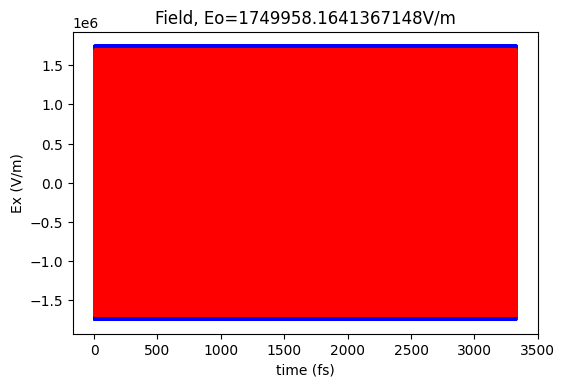

<Figure size 600x400 with 0 Axes>

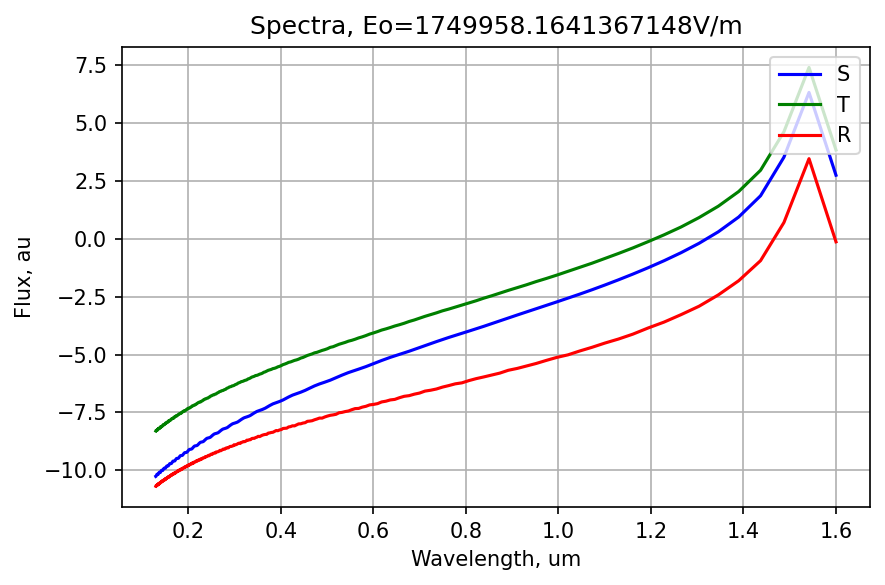

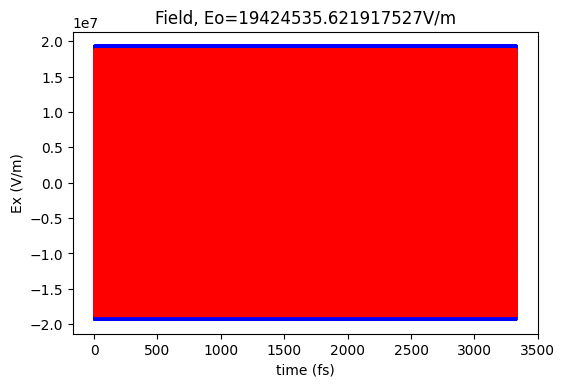

<Figure size 600x400 with 0 Axes>

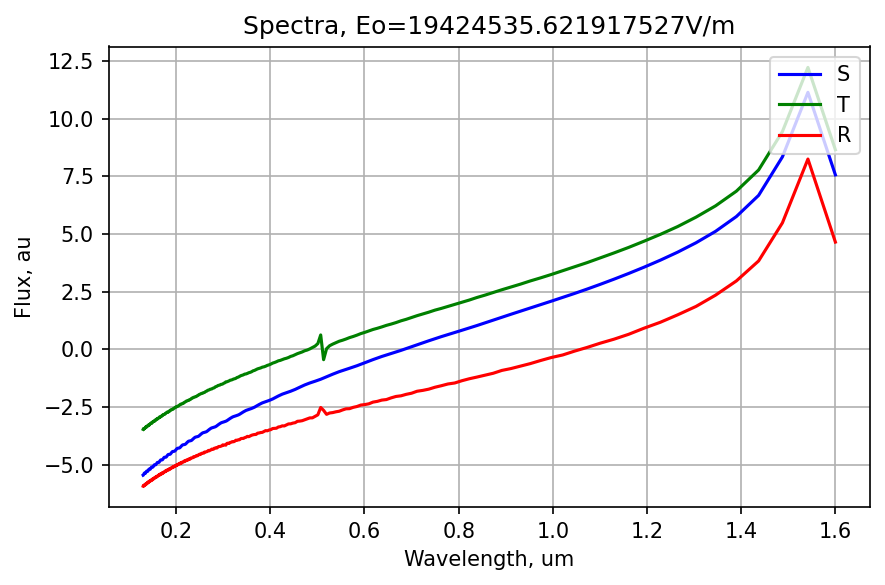

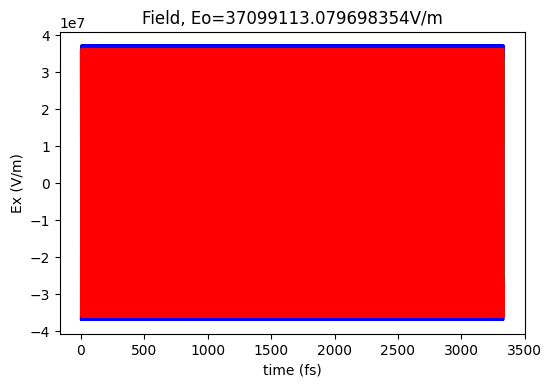

<Figure size 600x400 with 0 Axes>

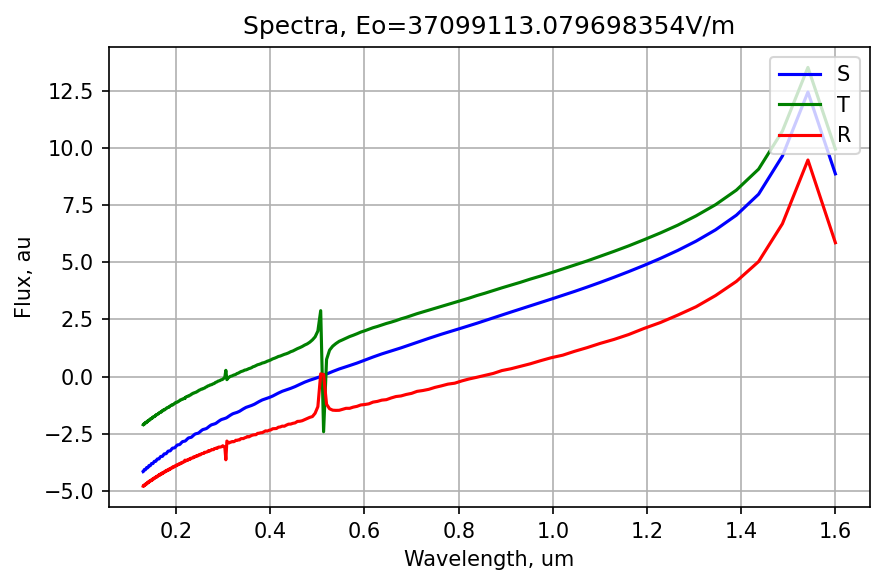

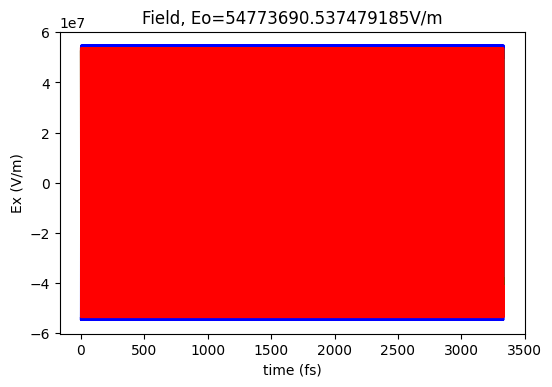

<Figure size 600x400 with 0 Axes>

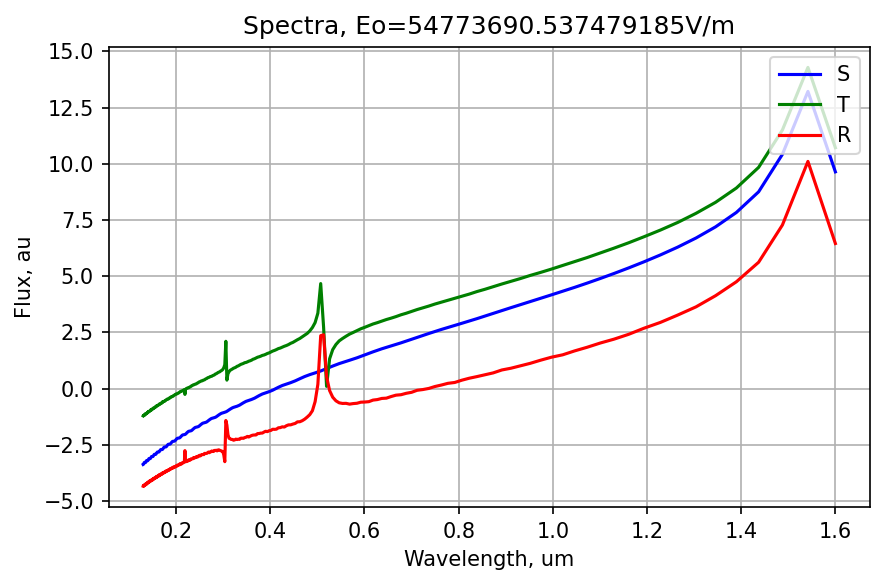

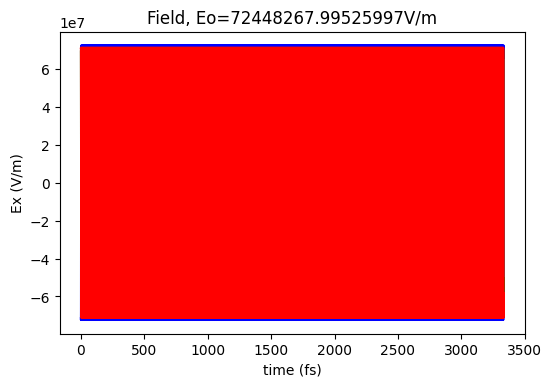

<Figure size 600x400 with 0 Axes>

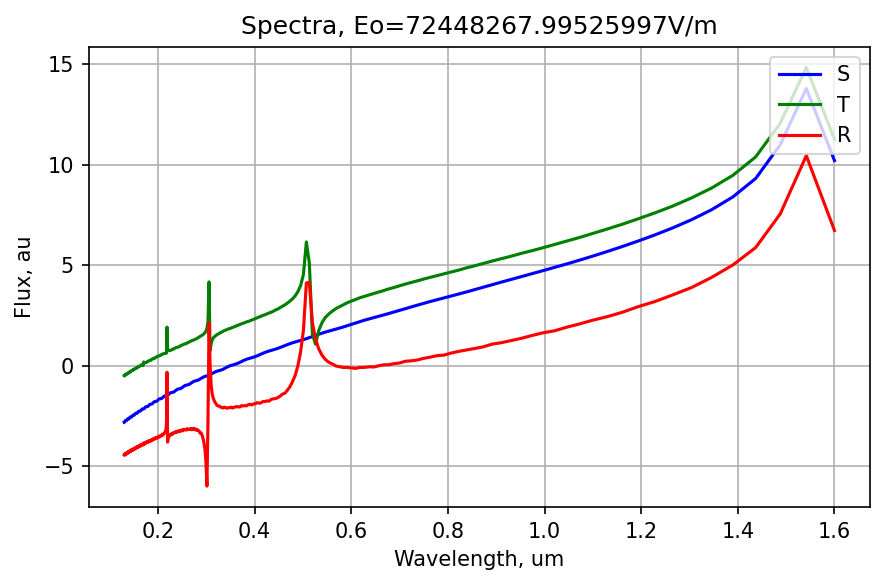

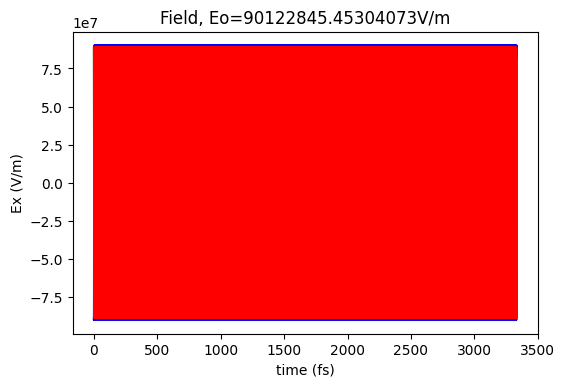

<Figure size 600x400 with 0 Axes>

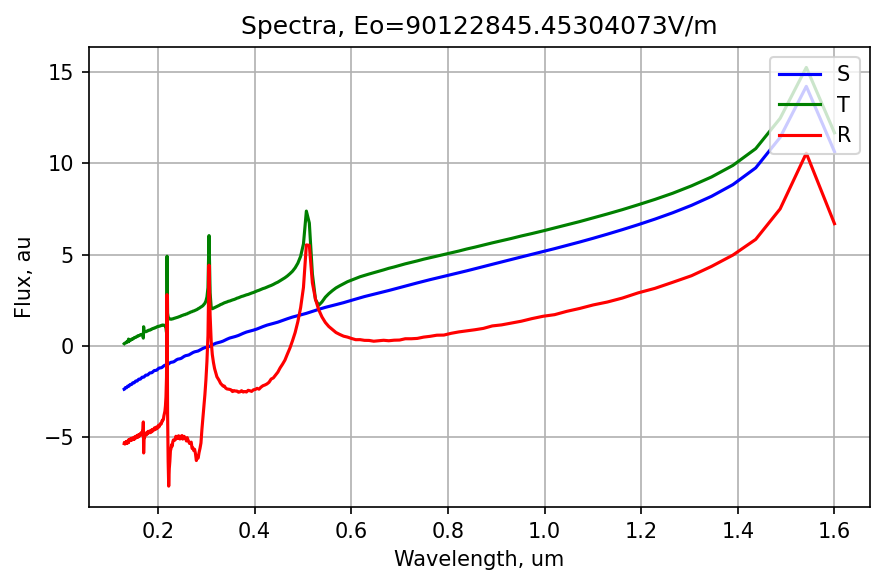

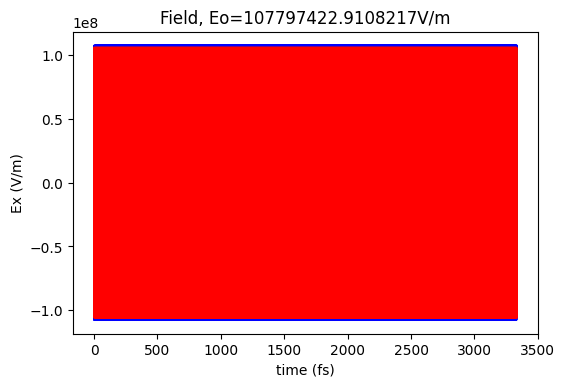

<Figure size 600x400 with 0 Axes>

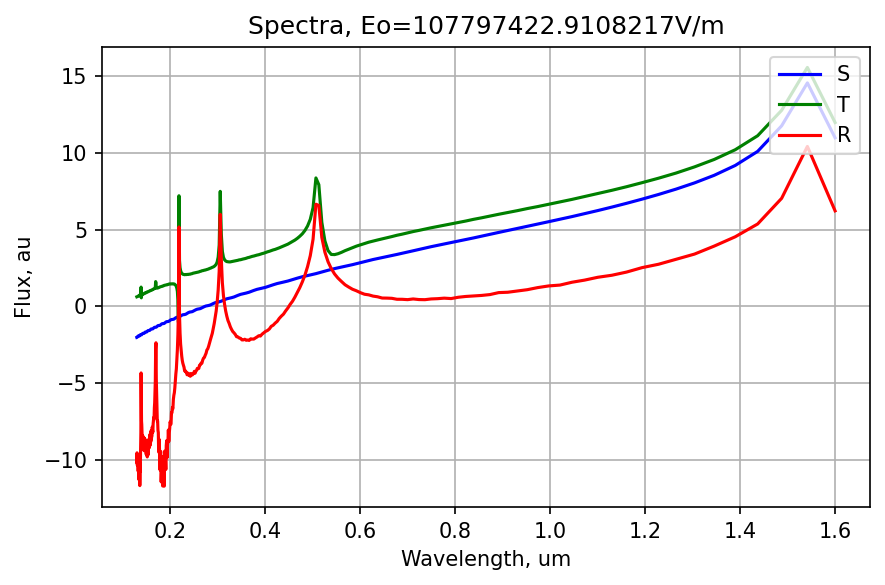

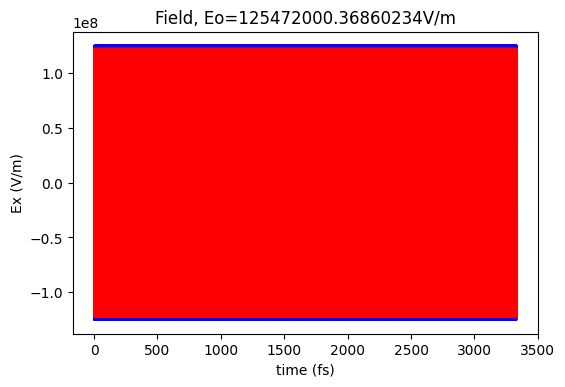

<Figure size 600x400 with 0 Axes>

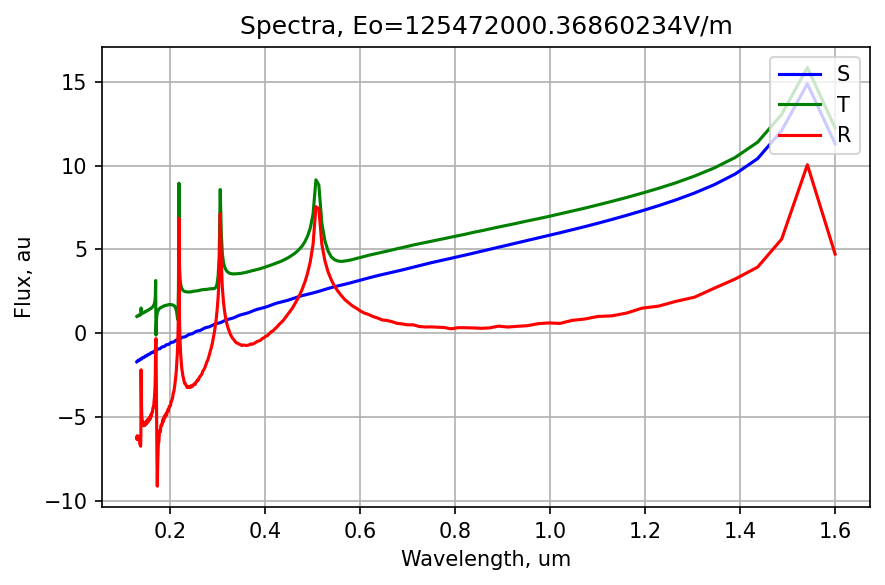

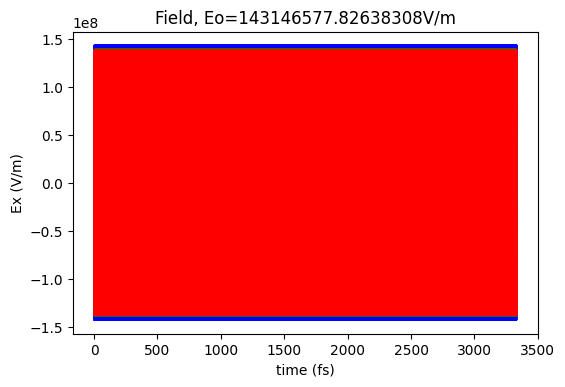

<Figure size 600x400 with 0 Axes>

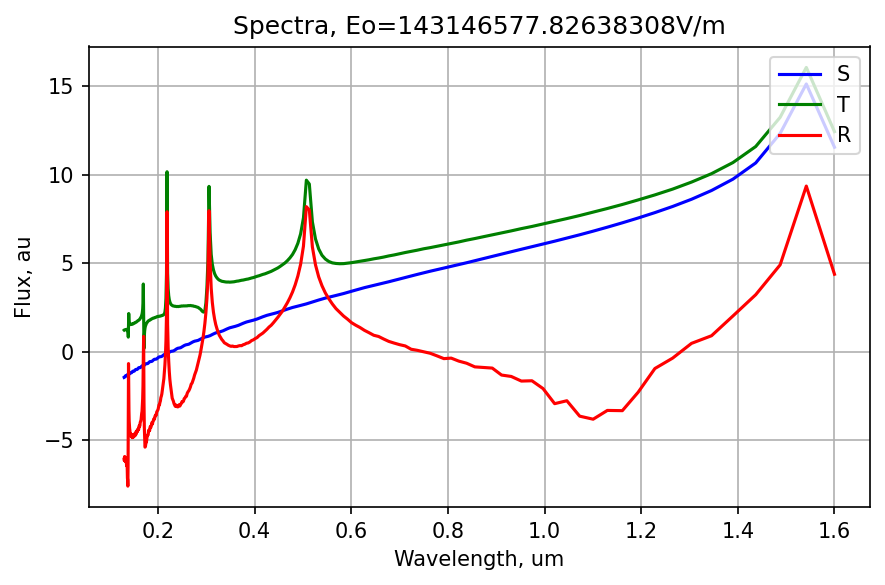

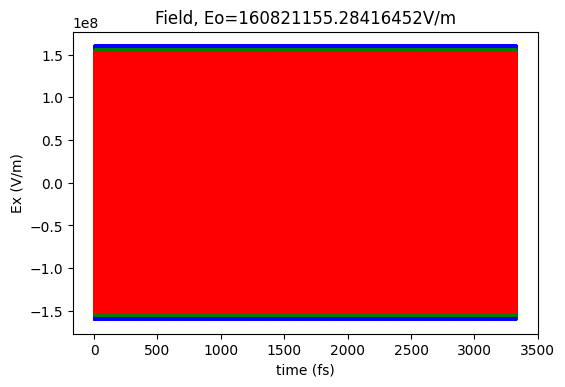

<Figure size 600x400 with 0 Axes>

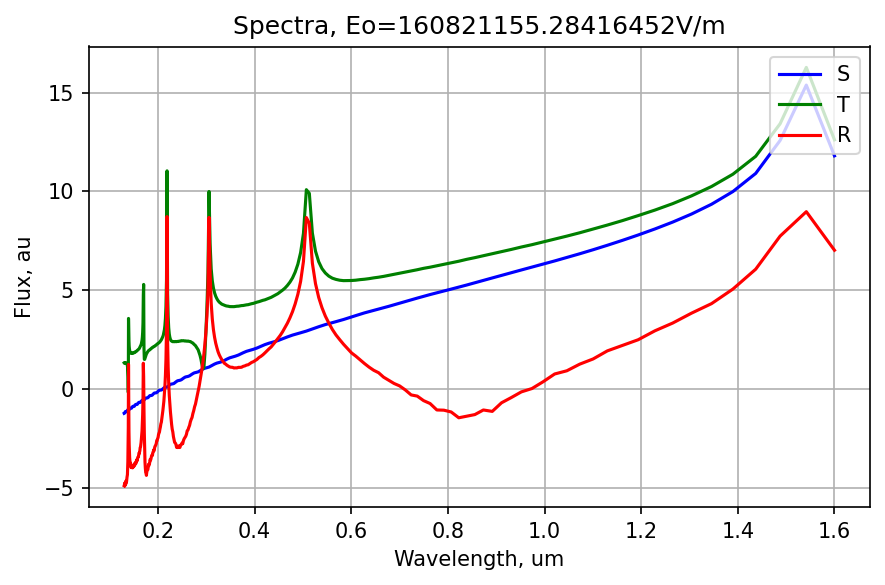

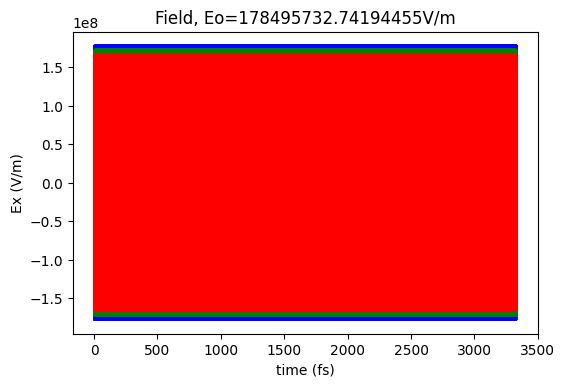

<Figure size 600x400 with 0 Axes>

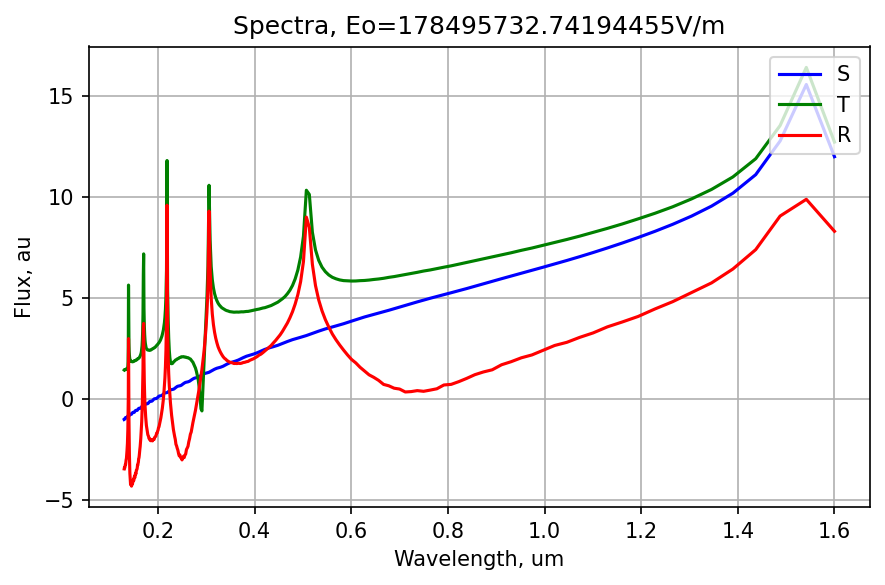

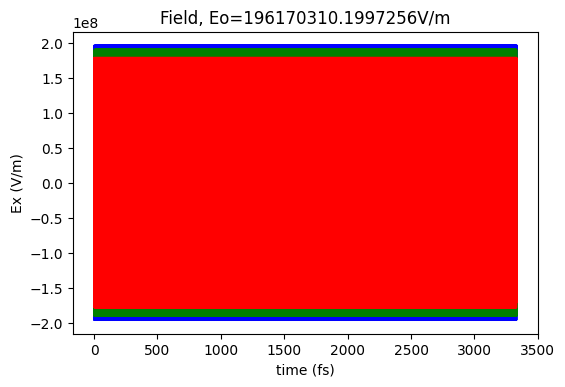

<Figure size 600x400 with 0 Axes>

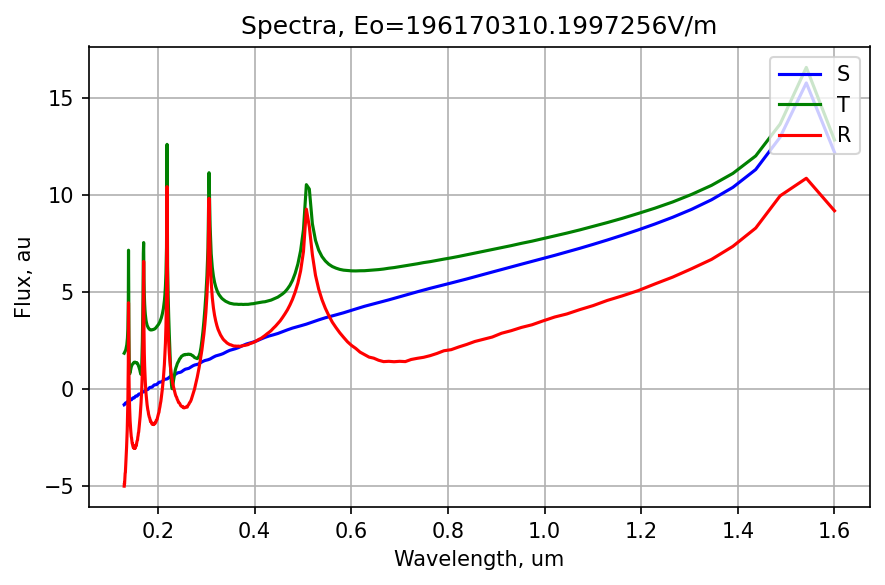

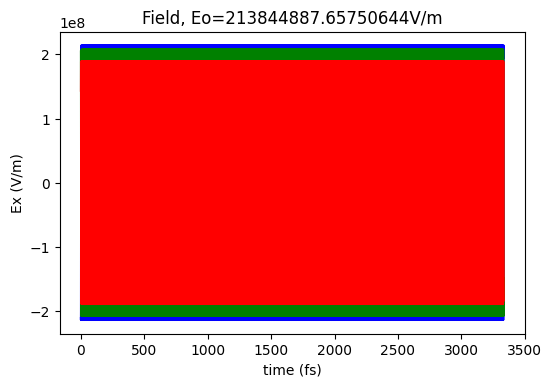

<Figure size 600x400 with 0 Axes>

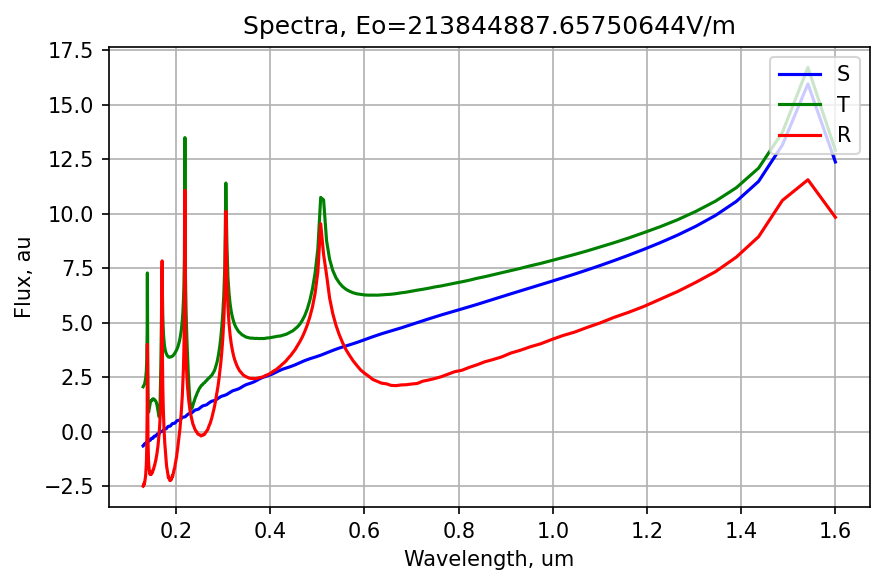

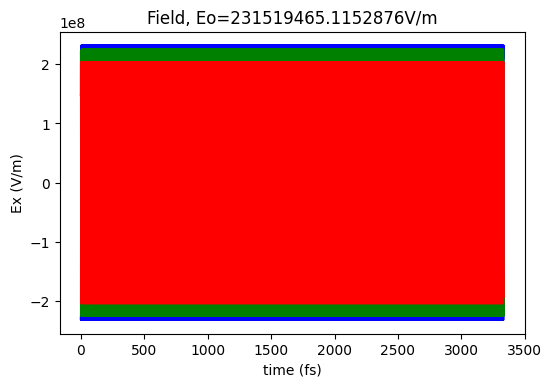

<Figure size 600x400 with 0 Axes>

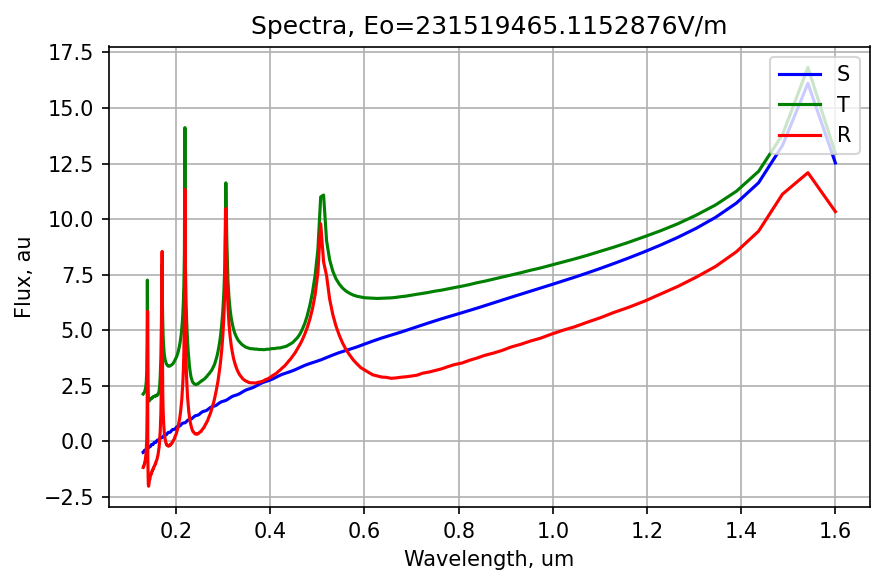

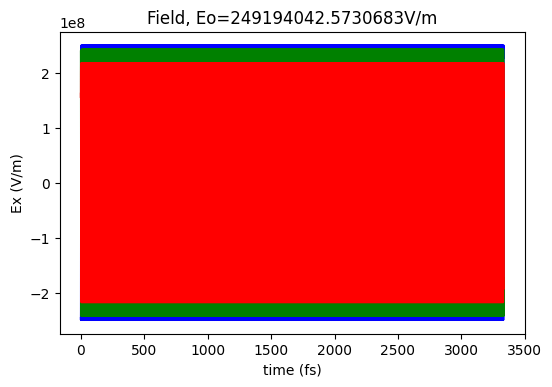

<Figure size 600x400 with 0 Axes>

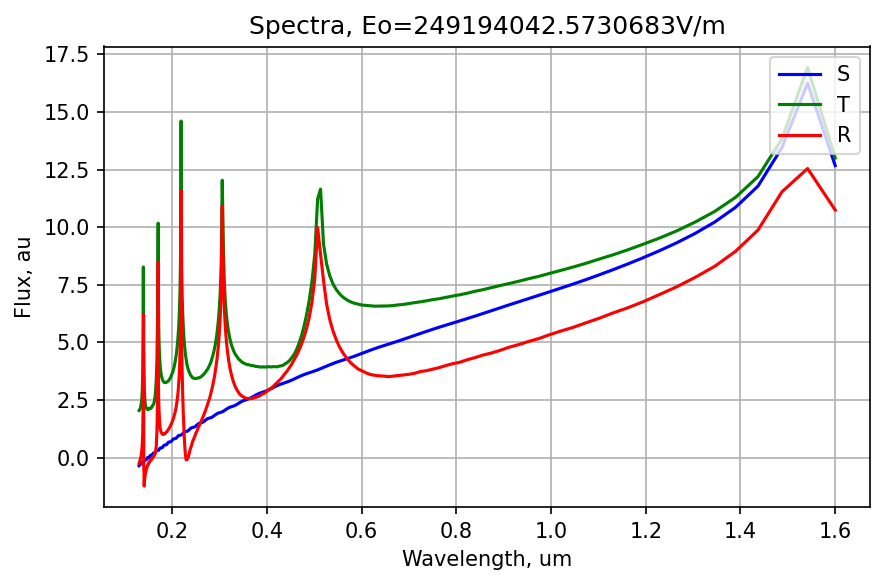

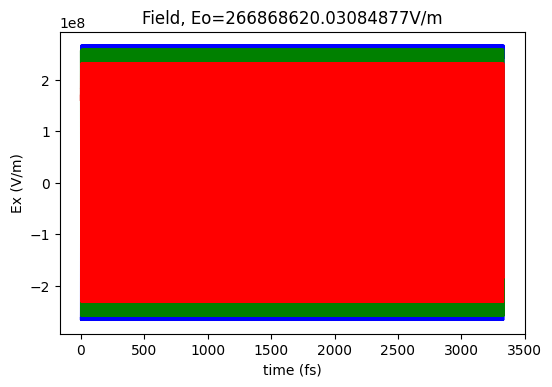

<Figure size 600x400 with 0 Axes>

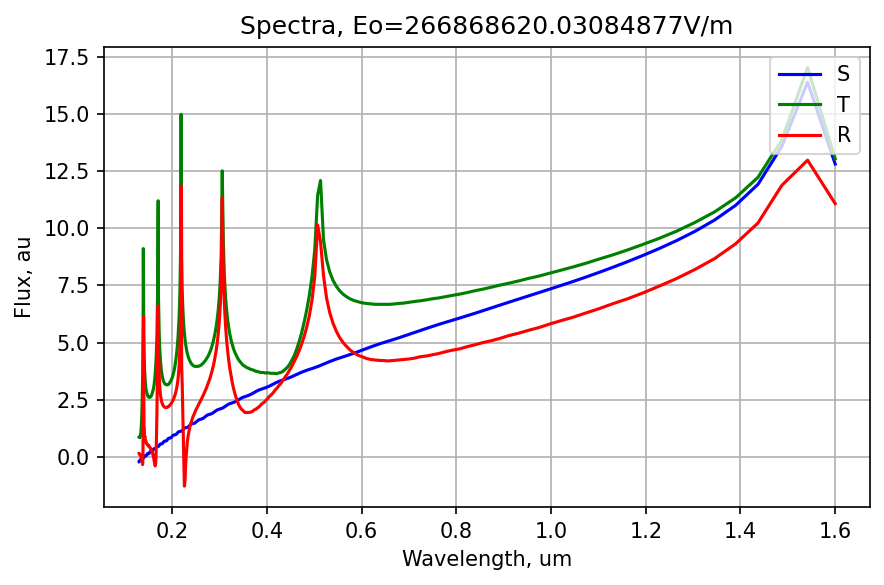

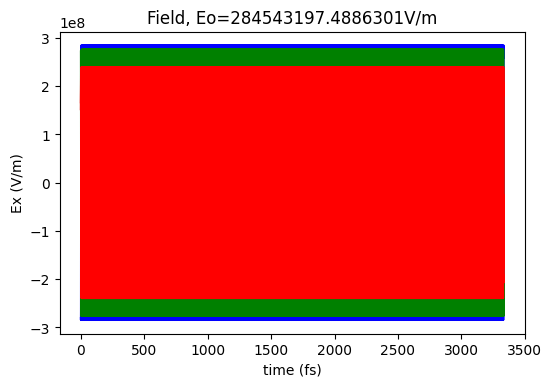

<Figure size 600x400 with 0 Axes>

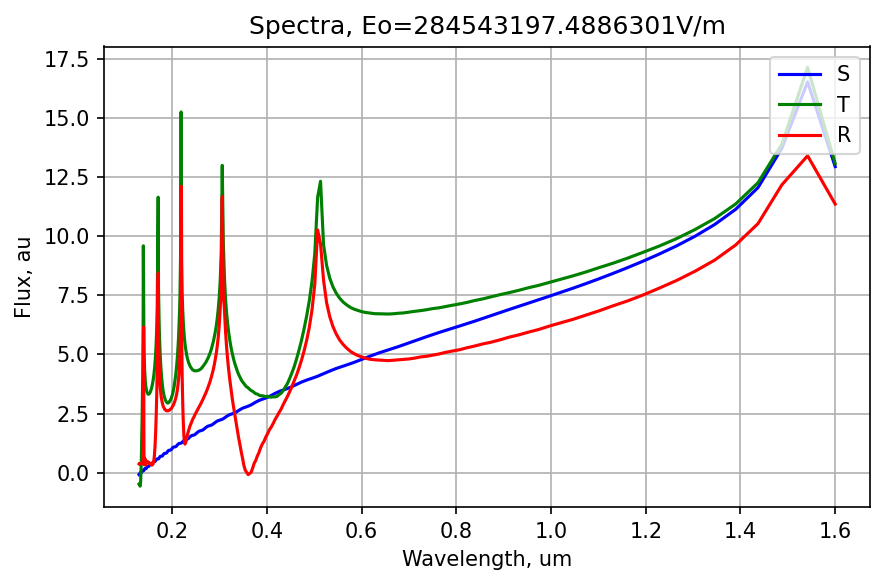

In [153]:
T_nl = np.empty(np.size(amp))
R_nl= np.empty(np.size(amp))
A_nl= np.empty(np.size(amp))
T_l= np.empty(np.size(amp))
R_l= np.empty(np.size(amp))
A_l= np.empty(np.size(amp))
E_out=np.empty(np.size(amp))
E_out2=np.empty(np.size(amp))
E_out3=np.empty(np.size(amp))
for j in range(np.size(amp)):
  print(j)
  E_out[j], E_out2[j], E_out3[j], plt_range, T_nl[j], R_nl[j], A_nl[j], T_l[j], R_l[j], A_l[j] = nl_cw(amp[j],resolution,k,n)

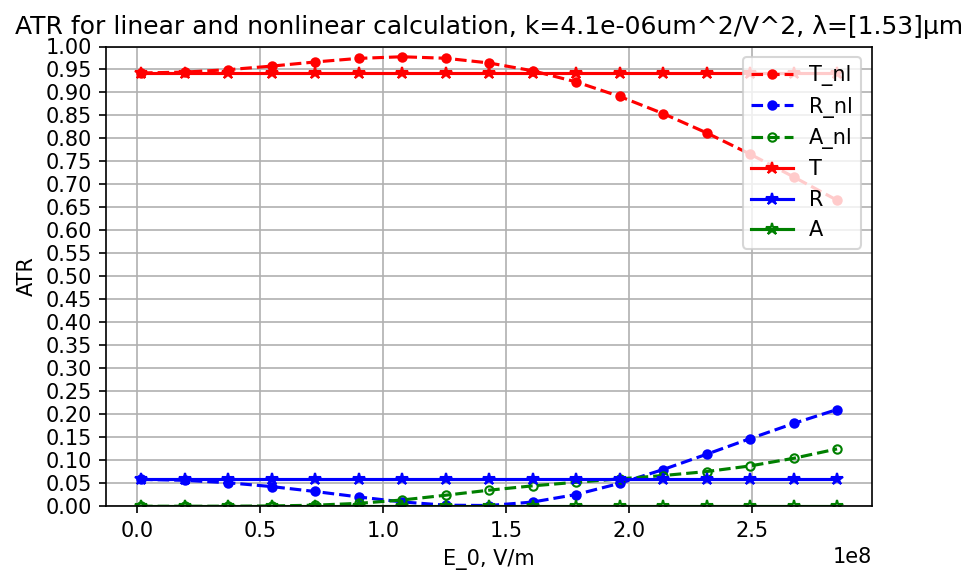

In [154]:
#         plot ATR
E_out[j], plt_range, T_nl[j], R_nl[j], A_nl[j], T_l[j], R_l[j], A_l[j]
plt.figure(dpi=150)
plt.plot(E_out,T_nl,'ro--',label='T_nl',markersize=4)
plt.plot(E_out,R_nl,'bo--',label='R_nl',markersize=4)
plt.plot(E_out,A_nl,'go--',label='A_nl',markersize=4, markerfacecolor='none')
plt.plot(E_out,T_l,'r*-',label='T')
plt.plot(E_out,R_l,'b*-',label='R')
plt.plot(E_out,A_l,'g*-',label='A', markerfacecolor='none')
plt.grid(True,which="both",ls="-")
#plt.xticks([0.2*10**8,0.4*10**8,0.6*10**8,0.8*10**8,1*10**8,1.2*10**8,1.2*10**8,1.4*10**8,1.6*10**8,1.8*10**8,2*10**8,2.2*10**8])
plt.yticks([-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95, 1])
#plt.xlim([0.1*10**8,2.4*10**8])
plt.xlabel('E_0, V/m')
plt.ylabel('ATR')
plt.legend(loc='upper right')
#plt.xlim([0.85, 5])
plt.ylim([-0, 1])
plt.title('ATR for linear and nonlinear calculation, k='+str(f"{k:03}")+'um^2/V^2, λ='+str(f"{plt_range}")+'μm')
plt.tight_layout()
np.savetxt('ATR_vs_E0.txt', (E_out,T_nl,R_nl,A_nl), delimiter=',')

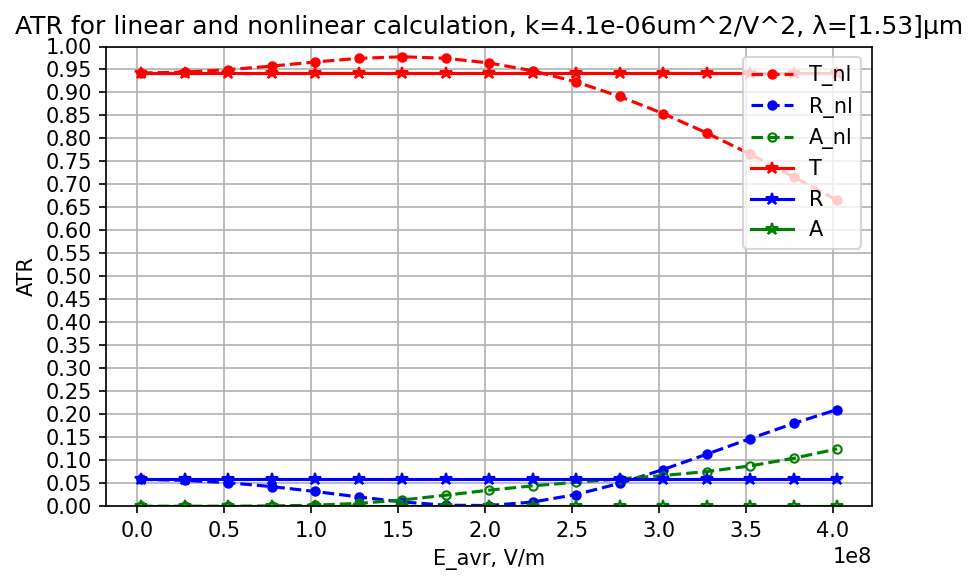

In [155]:
#         plot ATR
E_out[j], plt_range, T_nl[j], R_nl[j], A_nl[j], T_l[j], R_l[j], A_l[j]
plt.figure(dpi=150)
plt.plot(E_out*np.sqrt(2),T_nl,'ro--',label='T_nl',markersize=4)
plt.plot(E_out*np.sqrt(2),R_nl,'bo--',label='R_nl',markersize=4)
plt.plot(E_out*np.sqrt(2),A_nl,'go--',label='A_nl',markersize=4, markerfacecolor='none')
plt.plot(E_out*np.sqrt(2),T_l,'r*-',label='T')
plt.plot(E_out*np.sqrt(2),R_l,'b*-',label='R')
plt.plot(E_out*np.sqrt(2),A_l,'g*-',label='A', markerfacecolor='none')
plt.grid(True,which="both",ls="-")
plt.yticks([-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95, 1])
plt.xlabel('E_avr, V/m')
plt.ylabel('ATR')
plt.legend(loc='upper right')
#plt.xlim([0.85, 5])
plt.ylim([-0, 1])
plt.title('ATR for linear and nonlinear calculation, k='+str(f"{k:03}")+'um^2/V^2, λ='+str(f"{plt_range}")+'μm')
plt.tight_layout()
np.savetxt('ATR_vs_Eav.txt', (E_out*np.sqrt(2),T_nl,R_nl,A_nl), delimiter=',')

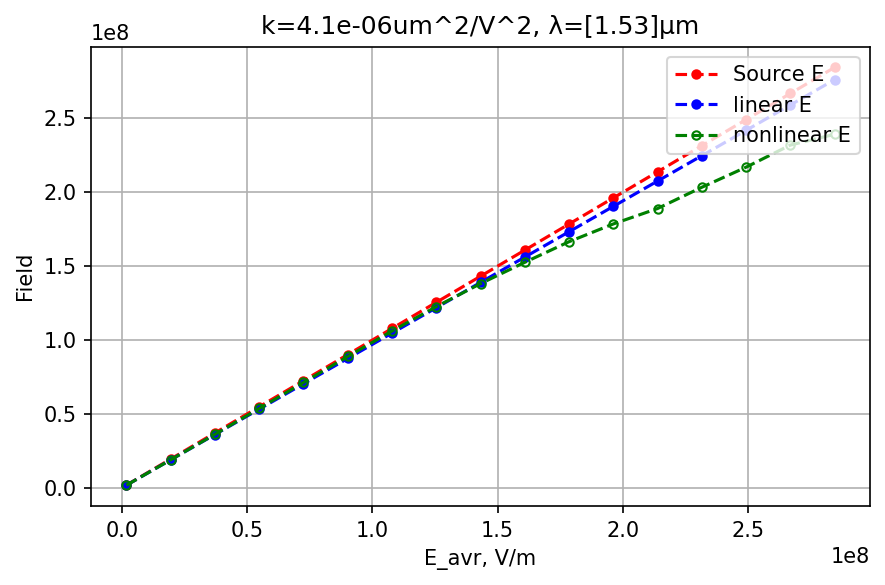

In [156]:
plt.figure(dpi=150)
plt.plot(E_out,E_out,'ro--',label='Source E',markersize=4)
plt.plot(E_out,E_out2,'bo--',label='linear E',markersize=4)
plt.plot(E_out,E_out3,'go--',label='nonlinear E',markersize=4, markerfacecolor='none')
plt.grid(True,which="both",ls="-")
plt.xlabel('E_avr, V/m')
plt.ylabel('Field')
plt.legend(loc='upper right')
#plt.xlim([0.85, 5])
#plt.ylim([-0, 1])
plt.title('k='+str(f"{k:03}")+'um^2/V^2, λ='+str(f"{plt_range}")+'μm')
plt.tight_layout()